### Import Major Libraries

In [210]:
import json
import requests
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

## Define Gameweek and Periods for FDR calculation

In [211]:
gameweek = 23
next_n_games = 2

#define percentage of time player needs to have played to be counted as active
min_min = ((gameweek-1)*90)/3.33     #<---- Currently 30% of playtime
print(min_min)

594.5945945945946


## Define Budget, Team Formation, and Budget Allocation by Position

In [212]:
#Budget
budget = 100

#Team Formation
DF = 3
MD = 4
ST = 3

#Total players needed per position
DF_max = 5
MD_max = 5
ST_max = 3

#Budget Allocation
GK_coef = 0.095
DF_coef = 0.285
MD_coef = 0.36
ST_coef = 0.26

print(sum([GK_coef, DF_coef, MD_coef, ST_coef]))

1.0


## Scraped list of Schedules

In [213]:
schedules = ['Arsenal NEW (A) BUR (H) LIV (A) TOT (H) WAT (A) AVL (H) MUN (A) BOU (H) SHU (A) CRY (H) WOL (H) LEI (A) SOU (H) NOR (A) BHA (H) WHU (A) MCI (H) EVE (A) BOU (A) CHE (H) MUN (H) CRY (A) SHU (H) CHE (A) BUR (A) NEW (H) EVE (H) MCI (A) WHU (H) BHA (A) SOU (A) NOR (H) WOL (A) LEI (H) TOT (A) LIV (H) AVL (A) WAT (H)',
 'Aston Villa TOT (A) BOU (H) EVE (H) CRY (A) WHU (H) ARS (A) BUR (H) NOR (A) BHA (H) MCI (A) LIV (H) WOL (A) NEW (H) MUN (A) CHE (A) LEI (H) SHU (A) SOU (H) NOR (H) WAT (A) BUR (A) MCI (H) BHA (A) WAT (H) BOU (A) TOT (H) SOU (A) SHU (H) LEI (A) CHE (H) NEW (A) WOL (H) LIV (A) MUN (H) CRY (H) EVE (A) ARS (H) WHU (A)',
 'Bournemouth SHU (H) AVL (A) MCI (H) LEI (A) EVE (H) SOU (A) WHU (H) ARS (A) NOR (H) WAT (A) MUN (H) NEW (A) WOL (H) TOT (A) CRY (A) LIV (H) CHE (A) BUR (H) ARS (H) BHA (A) WHU (A) WAT (H) NOR (A) BHA (H) AVL (H) SHU (A) BUR (A) CHE (H) LIV (A) CRY (H) WOL (A) NEW (H) MUN (A) TOT (H) LEI (H) MCI (A) SOU (H) EVE (A)',
 'Brighton WAT (A) WHU (H) SOU (H) MCI (A) BUR (H) NEW (A) CHE (A) TOT (H) AVL (A) EVE (H) NOR (H) MUN (A) LEI (H) LIV (A) ARS (A) WOL (H) CRY (A) SHU (H) TOT (A) BOU (H) CHE (H) EVE (A) AVL (H) BOU (A) WHU (A) WAT (H) SHU (A) CRY (H) WOL (A) ARS (H) LEI (A) MUN (H) NOR (A) LIV (H) MCI (H) SOU (A) NEW (H) BUR (A)',
 'Burnley SOU (H) ARS (A) WOL (A) LIV (H) BHA (A) NOR (H) AVL (A) EVE (H) LEI (A) CHE (H) SHU (A) WHU (H) WAT (A) CRY (H) MCI (H) TOT (A) NEW (H) BOU (A) EVE (A) MUN (H) AVL (H) CHE (A) LEI (H) MUN (A) ARS (H) SOU (A) BOU (H) NEW (A) TOT (H) MCI (A) WAT (H) CRY (A) SHU (H) WHU (A) LIV (A) WOL (H) NOR (A) BHA (H)',
 'Chelsea MUN (A) LEI (H) NOR (A) SHU (H) WOL (A) LIV (H) BHA (H) SOU (A) NEW (H) BUR (A) WAT (A) CRY (H) MCI (A) WHU (H) AVL (H) EVE (A) BOU (H) TOT (A) SOU (H) ARS (A) BHA (A) BUR (H) NEW (A) ARS (H) LEI (A) MUN (H) TOT (H) BOU (A) EVE (H) AVL (A) MCI (H) WHU (A) WAT (H) CRY (A) SHU (A) NOR (H) LIV (A) WOL (H)',
 'Crystal Palace EVE (H) SHU (A) MUN (A) AVL (H) TOT (A) WOL (H) NOR (H) WHU (A) MCI (H) ARS (A) LEI (H) CHE (A) LIV (H) BUR (A) BOU (H) WAT (A) BHA (H) NEW (A) WHU (H) SOU (A) NOR (A) ARS (H) MCI (A) SOU (H) SHU (H) EVE (A) NEW (H) BHA (A) WAT (H) BOU (A) LIV (A) BUR (H) LEI (A) CHE (H) AVL (A) MUN (H) WOL (A) TOT (H)',
 'Everton CRY (A) WAT (H) AVL (A) WOL (H) BOU (A) SHU (H) MCI (H) BUR (A) WHU (H) BHA (A) TOT (H) SOU (A) NOR (H) LEI (A) LIV (A) CHE (H) MUN (A) ARS (H) BUR (H) NEW (A) MCI (A) BHA (H) WHU (A) NEW (H) WAT (A) CRY (H) ARS (A) MUN (H) CHE (A) LIV (H) NOR (A) LEI (H) TOT (A) SOU (H) WOL (A) AVL (H) SHU (A) BOU (H)',
 'Leicester WOL (H) CHE (A) SHU (A) BOU (H) MUN (A) TOT (H) NEW (H) LIV (A) BUR (H) SOU (A) CRY (A) ARS (H) BHA (A) EVE (H) WAT (H) AVL (A) NOR (H) MCI (A) LIV (H) WHU (A) NEW (A) SOU (H) BUR (A) WHU (H) CHE (H) WOL (A) MCI (H) NOR (A) AVL (H) WAT (A) BHA (H) EVE (A) CRY (H) ARS (A) BOU (A) SHU (H) TOT (A) MUN (H)',
 'Liverpool NOR (H) SOU (A) ARS (H) BUR (A) NEW (H) CHE (A) SHU (A) LEI (H) MUN (A) TOT (H) AVL (A) MCI (H) CRY (A) BHA (H) EVE (H) BOU (A) WAT (H) WHU (A) LEI (A) WOL (H) SHU (H) TOT (A) MUN (H) WOL (A) SOU (H) NOR (A) WHU (H) WAT (A) BOU (H) EVE (A) CRY (H) MCI (A) AVL (H) BHA (A) BUR (H) ARS (A) CHE (H) NEW (A)',
 'Man City WHU (A) TOT (H) BOU (A) BHA (H) NOR (A) WAT (H) EVE (A) WOL (H) CRY (A) AVL (H) SOU (H) LIV (A) CHE (H) NEW (A) BUR (A) MUN (H) ARS (A) LEI (H) WOL (A) SHU (H) EVE (H) AVL (A) CRY (H) SHU (A) TOT (A) WHU (H) LEI (A) ARS (H) MUN (A) BUR (H) CHE (A) LIV (H) SOU (A) NEW (H) BHA (A) BOU (H) WAT (A) NOR (H)',
 'Man Utd CHE (H) WOL (A) CRY (H) SOU (A) LEI (H) WHU (A) ARS (H) NEW (A) LIV (H) NOR (A) BOU (A) BHA (H) SHU (A) AVL (H) TOT (H) MCI (A) EVE (H) WAT (A) NEW (H) BUR (A) ARS (A) NOR (H) LIV (A) BUR (H) WOL (H) CHE (A) WAT (H) EVE (A) MCI (H) TOT (A) SHU (H) BHA (A) BOU (H) AVL (A) SOU (H) CRY (A) WHU (H) LEI (A)',
 'Newcastle ARS (H) NOR (A) TOT (A) WAT (H) LIV (A) BHA (H) LEI (A) MUN (H) CHE (A) WOL (H) WHU (A) BOU (H) AVL (A) MCI (H) SHU (A) SOU (H) BUR (A) CRY (H) MUN (A) EVE (H) LEI (H) WOL (A) CHE (H) EVE (A) NOR (H) ARS (A) CRY (A) BUR (H) SOU (A) SHU (H) AVL (H) BOU (A) WHU (H) MCI (A) WAT (A) TOT (H) BHA (A) LIV (H)',
 'Norwich LIV (A) NEW (H) CHE (H) WHU (A) MCI (H) BUR (A) CRY (A) AVL (H) BOU (A) MUN (H) BHA (A) WAT (H) EVE (A) ARS (H) SOU (A) SHU (H) LEI (A) WOL (H) AVL (A) TOT (H) CRY (H) MUN (A) BOU (H) TOT (A) NEW (A) LIV (H) WOL (A) LEI (H) SHU (A) SOU (H) EVE (H) ARS (A) BHA (H) WAT (A) WHU (H) CHE (A) BUR (H) MCI (A)',
 'Sheffield Utd BOU (A) CRY (H) LEI (H) CHE (A) SOU (H) EVE (A) LIV (H) WAT (A) ARS (H) WHU (A) BUR (H) TOT (A) MUN (H) WOL (A) NEW (H) NOR (A) AVL (H) BHA (A) WAT (H) MCI (A) LIV (A) WHU (H) ARS (A) MCI (H) CRY (A) BOU (H) BHA (H) AVL (A) NOR (H) NEW (A) MUN (A) TOT (H) BUR (A) WOL (H) CHE (H) LEI (A) EVE (H) SOU (A)',
 'Southampton BUR (A) LIV (H) BHA (A) MUN (H) SHU (A) BOU (H) TOT (A) CHE (H) WOL (A) LEI (H) MCI (A) EVE (H) ARS (A) WAT (H) NOR (H) NEW (A) WHU (H) AVL (A) CHE (A) CRY (H) TOT (H) LEI (A) WOL (H) CRY (A) LIV (A) BUR (H) AVL (H) WHU (A) NEW (H) NOR (A) ARS (H) WAT (A) MCI (H) EVE (A) MUN (A) BHA (H) BOU (A) SHU (H)',
 'Spurs AVL (H) MCI (A) NEW (H) ARS (A) CRY (H) LEI (A) SOU (H) BHA (A) WAT (H) LIV (A) EVE (A) SHU (H) WHU (A) BOU (H) MUN (A) BUR (H) WOL (A) CHE (H) BHA (H) NOR (A) SOU (A) LIV (H) WAT (A) NOR (H) MCI (H) AVL (A) CHE (A) WOL (H) BUR (A) MUN (H) WHU (H) SHU (A) EVE (H) BOU (A) ARS (H) NEW (A) LEI (H) CRY (A)',
 'Watford BHA (H) EVE (A) WHU (H) NEW (A) ARS (H) MCI (A) WOL (A) SHU (H) TOT (A) BOU (H) CHE (H) NOR (A) BUR (H) SOU (A) LEI (A) CRY (H) LIV (A) MUN (H) SHU (A) AVL (H) WOL (H) BOU (A) TOT (H) AVL (A) EVE (H) BHA (A) MUN (A) LIV (H) CRY (A) LEI (H) BUR (A) SOU (H) CHE (A) NOR (H) NEW (H) WHU (A) MCI (H) ARS (A)',
 'West Ham MCI (H) BHA (A) WAT (A) NOR (H) AVL (A) MUN (H) BOU (A) CRY (H) EVE (A) SHU (H) NEW (H) BUR (A) TOT (H) CHE (A) WOL (A) ARS (H) SOU (A) LIV (H) CRY (A) LEI (H) BOU (H) SHU (A) EVE (H) LEI (A) BHA (H) MCI (A) LIV (A) SOU (H) ARS (A) WOL (H) TOT (A) CHE (H) NEW (A) BUR (H) NOR (A) WAT (H) MUN (A) AVL (H)',
 'Wolves LEI (A) MUN (H) BUR (H) EVE (A) CHE (H) CRY (A) WAT (H) MCI (A) SOU (H) NEW (A) ARS (A) AVL (H) BOU (A) SHU (H) WHU (H) BHA (A) TOT (H) NOR (A) MCI (H) LIV (A) WAT (A) NEW (H) SOU (A) LIV (H) MUN (A) LEI (H) NOR (H) TOT (A) BHA (H) WHU (A) BOU (H) AVL (A) ARS (H) SHU (A) EVE (H) BUR (A) CRY (H) CHE (A)']

### Import Data

In [214]:


# url = "https://fantasy.premierleague.com/drf/bootstrap-static"
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'

def get_json_data(url):
    response = requests.get(url)
    jobs = response.json()
    return jobs

#filter out players with less than 330
all_players = get_json_data(url)['elements']
all_teams = get_json_data(url)['teams']
positions = get_json_data(url)['element_types']

In [215]:
all_players[0]

{'chance_of_playing_next_round': 100,
 'chance_of_playing_this_round': 100,
 'code': 69140,
 'cost_change_event': 0,
 'cost_change_event_fall': 0,
 'cost_change_start': -3,
 'cost_change_start_fall': 3,
 'dreamteam_count': 0,
 'element_type': 2,
 'ep_next': '0.8',
 'ep_this': '0.8',
 'event_points': 0,
 'first_name': 'Shkodran',
 'form': '0.3',
 'id': 1,
 'in_dreamteam': False,
 'news': '',
 'news_added': '2019-11-28T23:00:21.541666Z',
 'now_cost': 52,
 'photo': '69140.jpg',
 'points_per_game': '2.0',
 'second_name': 'Mustafi',
 'selected_by_percent': '0.3',
 'special': False,
 'squad_number': None,
 'status': 'a',
 'team': 1,
 'team_code': 3,
 'total_points': 6,
 'transfers_in': 8659,
 'transfers_in_event': 112,
 'transfers_out': 33591,
 'transfers_out_event': 272,
 'value_form': '0.1',
 'value_season': '1.2',
 'web_name': 'Mustafi',
 'minutes': 170,
 'goals_scored': 0,
 'assists': 1,
 'clean_sheets': 0,
 'goals_conceded': 4,
 'own_goals': 0,
 'penalties_saved': 0,
 'penalties_missed'

### Get Team Table

In [216]:
table_url = 'https://www.premierleague.com/tables'

def build_table(table_url):
    team_table = pd.read_html(table_url)
    team_df = pd.DataFrame(team_table[0])
    team_df = team_df[team_df['Unnamed: 12'].isna()]
    team_df = team_df.iloc[:,1:10]
    team_df.Club = team_df.Club.map(lambda x: x[-3:])
    team_df.reset_index()
    team_df.index = np.arange(1, len(team_df) + 1)
    team_df.columns = ['Team', 'Played', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts']
    team_df.index.name = 'Position'
    
    return team_df

In [217]:
table_url = 'https://www.premierleague.com/tables'
team_table = pd.read_html(table_url)
team_table[0]

,Position Pos,Club,Played Pl,Won W,Drawn D,Lost L,GF,GA,GD,Points Pts,Form,Next,Unnamed: 12
0,1 Previous Position 1,LiverpoolLIV,21,20,1,0,50,14,+36,61,W Saturday 14 December 2019 LIV 2 -0 WAT ...,Manchester United Sunday 19 January 2020 LIV...,NaN
1,Liverpool Recent Result - Saturday 11 January...,Liverpool Recent Result - Saturday 11 January...,Liverpool Recent Result - Saturday 11 January...,Liverpool Recent Result - Saturday 11 January...,Liverpool Recent Result - Saturday 11 January...,Liverpool Recent Result - Saturday 11 January...,Liverpool Recent Result - Saturday 11 January...,Liverpool Recent Result - Saturday 11 January...,Liverpool Recent Result - Saturday 11 January...,Liverpool Recent Result - Saturday 11 January...,Liverpool Recent Result - Saturday 11 January...,Liverpool Recent Result - Saturday 11 January...,Liverpool Recent Result - Saturday 11 January...
2,2 Previous Position 3,Manchester CityMCI,22,15,2,5,62,25,+37,47,W Saturday 21 December 2019 MCI 3 -1 LEI ...,Crystal Palace Saturday 18 January 2020 MCI ...,NaN
3,Manchester City Recent Result - Sunday 12 Jan...,Manchester City Recent Result - Sunday 12 Jan...,Manchester City Recent Result - Sunday 12 Jan...,Manchester City Recent Result - Sunday 12 Jan...,Manchester City Recent Result - Sunday 12 Jan...,Manchester City Recent Result - Sunday 12 Jan...,Manchester City Recent Result - Sunday 12 Jan...,Manchester City Recent Result - Sunday 12 Jan...,Manchester City Recent Result - Sunday 12 Jan...,Manchester City Recent Result - Sunday 12 Jan...,Manchester City Recent Result - Sunday 12 Jan...,Manchester City Recent Result - Sunday 12 Jan...,Manchester City Recent Result - Sunday 12 Jan...
4,3 Previous Position 2,Leicester CityLEI,22,14,3,5,47,21,+26,45,L Saturday 21 December 2019 MCI 3 -1 LEI ...,Burnley Sunday 19 January 2020 BUR 14:00 LEI,NaN
5,Leicester City Recent Result - Saturday 11 Ja...,Leicester City Recent Result - Saturday 11 Ja...,Leicester City Recent Result - Saturday 11 Ja...,Leicester City Recent Result - Saturday 11 Ja...,Leicester City Recent Result - Saturday 11 Ja...,Leicester City Recent Result - Saturday 11 Ja...,Leicester City Recent Result - Saturday 11 Ja...,Leicester City Recent Result - Saturday 11 Ja...,Leicester City Recent Result - Saturday 11 Ja...,Leicester City Recent Result - Saturday 11 Ja...,Leicester City Recent Result - Saturday 11 Ja...,Leicester City Recent Result - Saturday 11 Ja...,Leicester City Recent Result - Saturday 11 Ja...
6,4 Previous Position 4,ChelseaCHE,22,12,3,7,39,29,+10,39,W Sunday 22 December 2019 TOT 0 -2 CHE L ...,Newcastle United Saturday 18 January 2020 NE...,NaN
7,Chelsea Recent Result - Saturday 11 January 2...,Chelsea Recent Result - Saturday 11 January 2...,Chelsea Recent Result - Saturday 11 January 2...,Chelsea Recent Result - Saturday 11 January 2...,Chelsea Recent Result - Saturday 11 January 2...,Chelsea Recent Result - Saturday 11 January 2...,Chelsea Recent Result - Saturday 11 January 2...,Chelsea Recent Result - Saturday 11 January 2...,Chelsea Recent Result - Saturday 11 January 2...,Chelsea Recent Result - Saturday 11 January 2...,Chelsea Recent Result - Saturday 11 January 2...,Chelsea Recent Result - Saturday 11 January 2...,Chelsea Recent Result - Saturday 11 January 2...
8,5 Previous Position 5,Manchester UnitedMUN,22,9,7,6,36,25,+11,34,L Sunday 22 December 2019 WAT 2 -0 MUN W ...,Liverpool Sunday 19 January 2020 LIV 16:30 ...,NaN
9,Manchester United Recent Result - Saturday 11...,Manchester United Recent Result - Saturday 11...,Manchester United Recent Result - Saturday 11...,Manchester United Recent Result - Saturday 11...,Manchester United Recent Result - Saturday 11...,Manchester United Recent Result - Saturday 11...,Manchester United Recent Result - Saturday 11...,Manchester United Recent Result - Saturday 11...,Manchester United Recent Result - Saturday 11...,Manchester United Recent Result - Saturday 11...,Manchester United Recent Result - Saturday 11...,Manchester Uni

In [218]:
table_df = build_table(table_url)

In [219]:
table_df.head()

,Team,Played,W,D,L,GF,GA,GD,Pts
Position,,,,,,,,,
1,LIV,21,20,1,0,50,14,+36,61
2,MCI,22,15,2,5,62,25,+37,47
3,LEI,22,14,3,5,47,21,+26,45
4,CHE,22,12,3,7,39,29,+10,39
5,MUN,22,9,7,6,36,25,+11,34


### Try dynamic FDR Score

In [220]:
#List of teams
name_list = list(table_df.Team)

#list of points as integers
pts_list = [int(item) for item in table_df.Pts]
top_pts = max(pts_list)

#list of GF as integers
GF_list = [int(item) for item in table_df.GF]
top_GF = max(GF_list)

#list of GA as integers
GA_list = [int(item) for item in table_df.GA]
top_GA = max(GA_list)

In [221]:
top_pts, top_GF, top_GA

(61, 62, 45)

In [222]:
name_list[:5]

['LIV', 'MCI', 'LEI', 'CHE', 'MUN']

In [223]:
from scipy import stats
stats.percentileofscore(GF_list, 20)

10.0

In [224]:
scaled = [pts_list, GF_list, GA_list]

### Write Function to try scaled scores

In [225]:
def scaled_FDR(pts_list, GF_list, GA_list):
    #turn to array so you an use scaler
    arr_pts = np.array(pts_list).reshape(-1, 1)
    arr_GF = np.array(GF_list).reshape(-1, 1)
    arr_GA = np.array(GA_list).reshape(-1, 1)
    
    #instantiate scalers
    minmax = MinMaxScaler()
    robust = RobustScaler()
    
    #apply MinMax
    minmax_pts = minmax.fit_transform(arr_pts)
    minmax_GF = minmax.fit_transform(arr_GF)
    minmax_GA = minmax.fit_transform(arr_GA)
    
    #apply Robust
    robu_pts = robust.fit_transform(arr_pts)
    robu_GF = robust.fit_transform(arr_GF)
    robu_GA = robust.fit_transform(arr_GA)
    
    #add normalzied scores
    sum_minmax = (minmax_pts + minmax_GF + (1 - minmax_GA)).tolist()
    sum_robu = (robu_pts + robu_GF + minmax_GA*(-1)).tolist()
    
    minmax_fin = [item[0] for item in sum_minmax]
    robu_fin = [item[0] for item in sum_robu]
    
    return (minmax_fin, robu_fin)
    

In [226]:
scaled_scores = scaled_FDR(pts_list, GF_list, GA_list)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [227]:
scaled_scores[1]

[5.586666666666666,
 4.6362724014336925,
 3.343082437275986,
 1.7783512544802869,
 1.1118279569892475,
 0.0586379928315412,
 0.28172043010752695,
 0.47383512544802864,
 -0.6914695340501792,
 -0.3083870967741935,
 -0.6606451612903225,
 -0.7264516129032258,
 -1.2673835125448027,
 -1.0405734767025088,
 -1.3463799283154123,
 -1.359569892473118,
 -1.791827956989247,
 -1.5532616487455195,
 -2.0463082437275983,
 -2.8755555555555556]

In [228]:
maybs = [item*2 for item in scaled_scores[0]]

In [229]:
maybs

[5.428571428571429,
 4.694577899794098,
 4.153250318658692,
 3.000849756512076,
 2.9032911723371573,
 2.5048207340588946,
 2.3439879726770596,
 2.345981632186162,
 1.993136582017845,
 1.9275419158741054,
 1.672549596365657,
 1.3161747883779455,
 1.2679347648462271,
 1.631369088472726,
 1.132137137627872,
 1.3527143183972288,
 1.0501029512697326,
 0.8078569794424293,
 0.9004804392587512,
 0.09523809523809512]

<function matplotlib.pyplot.show(*args, **kw)>

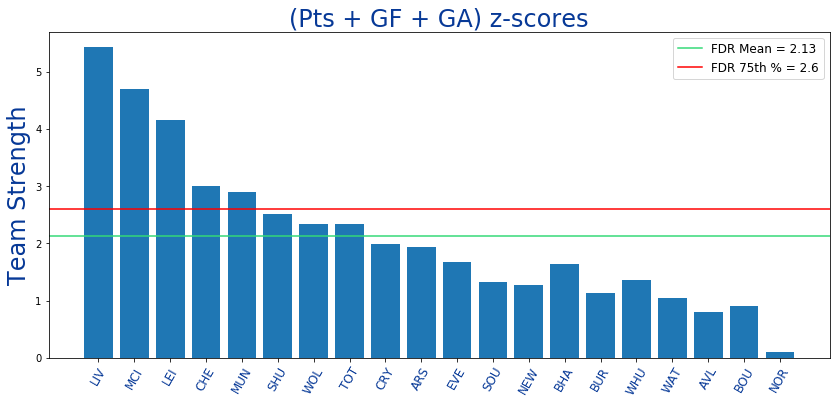

In [230]:
Team = name_list
strength = maybs

mean_FDR = round(np.mean([item for item in maybs]), 2)
FDR_75 = round(np.percentile([item for item in maybs], 75), 2)

plt.bar(Team, strength)
plt.axhline(y=mean_FDR, linestyle='-', color='#33D977', label='FDR Mean = ' + str(mean_FDR))
plt.axhline(y=FDR_75, linestyle='-', color='red', label='FDR 75th % = ' + str(FDR_75))
plt.ylabel('Team Strength', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('(Pts + GF + GA) z-scores', fontsize = 24, color = '#073997')
plt.legend(fontsize = '12')
plt.show

In [231]:
# import plotly.graph_objs as go


# fig = go.Figure([go.Bar(x=Team, y=strength, marker = {'color': '#82DFF1'})])
# fig.add_trace(go.Scatter(
#     x=['LIV', 'WAT'],
#     y=[mean_FDR, mean_FDR],
#     mode="lines",
# ))

# fig.layout.plot_bgcolor = '#082391'                
# fig.update_layout(
#     title='US Export of Plastic Scrap',
#     xaxis_tickfont_size=14,
#     yaxis=dict(
#         title='USD (millions)',
#         showgrid=False,
#         titlefont_size=16,
#         tickfont_size=14,
#     ))

# fig.write_image('figure.png')
# fig.show()

In [232]:
zipped_list = list(zip(name_list, pts_list, GF_list, GA_list))

In [233]:
zipped_list[:3]

[('LIV', 61, 50, 14), ('MCI', 47, 62, 25), ('LEI', 45, 47, 21)]

In [234]:
def get_percentiles(zipped_list):
    listy = []
    for item in zipped_list:
        team = item[0]
        pts_perc = stats.percentileofscore(pts_list, item[1])
        GF_perc = stats.percentileofscore(GF_list, item[2])
        GA_perc = stats.percentileofscore(GA_list, item[3])
        FDR = pts_perc + GF_perc + (100-GA_perc)
        tup = (team, FDR)
        listy.append(tup)
    return listy
    

In [235]:
FDR_new = get_percentiles(zipped_list)

In [236]:
FDR_new

[('LIV', 290.0),
 ('MCI', 267.5),
 ('LEI', 267.5),
 ('CHE', 230.0),
 ('MUN', 230.0),
 ('SHU', 195.0),
 ('WOL', 205.0),
 ('TOT', 190.0),
 ('CRY', 150.0),
 ('ARS', 162.5),
 ('EVE', 135.0),
 ('SOU', 115.0),
 ('NEW', 87.5),
 ('BHA', 132.5),
 ('BUR', 80.0),
 ('WHU', 102.5),
 ('WAT', 60.0),
 ('AVL', 80.0),
 ('BOU', 40.0),
 ('NOR', 30.0)]

In [237]:
mean_FDR = np.mean([item[1] for item in FDR_new])

In [238]:
mean_FDR

152.5

<function matplotlib.pyplot.show(*args, **kw)>

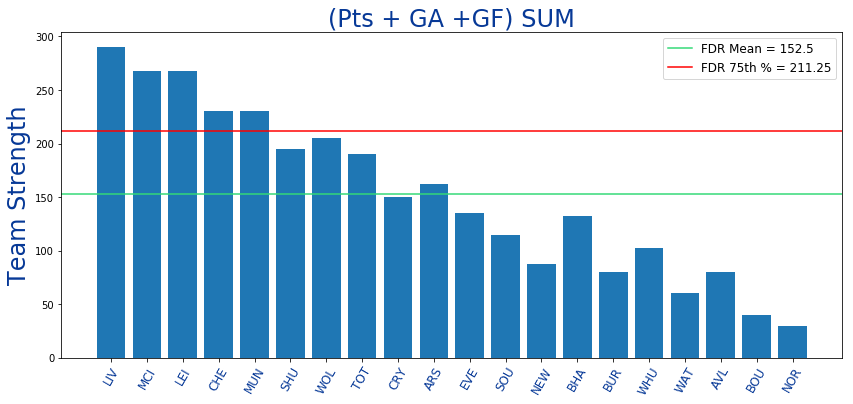

In [239]:
Team = [item[0] for item in FDR_new]
strength = [item[1] for item in FDR_new]

mean_FDR = np.mean([item[1] for item in FDR_new])
FDR_75 = np.percentile([item[1] for item in FDR_new], 75)

plt.bar(Team, strength)
plt.axhline(y=mean_FDR, linestyle='-', color='#33D977', label='FDR Mean = ' + str(mean_FDR))
plt.axhline(y=FDR_75, linestyle='-', color='red', label='FDR 75th % = ' + str(FDR_75))
plt.ylabel('Team Strength', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('(Pts + GA +GF) SUM', fontsize = 24, color = '#073997')
plt.legend(fontsize = '12')
plt.show

### Function to return percentile for each team

## Add player status and ROI, pts-per-90min metrics to final player_df

In [240]:
def attach_team_and_position(main_players, all_teams, positons):
    players = main_players.copy()
    for team in all_teams:
        for player in players:
            if team['code'] == player['team_code']:
                player['team_name'] = team['name']
    for position in positions:
        for player in players:
            if position['id'] == player['element_type']:
                player['position'] = position['singular_name']
    for player in players:
        if player['status'] == "a":
            player['status'] = "available"
        elif player['status'] == "d":
            player['status'] = "doubtful"
        elif player['status'] == "i":
            player['status'] = "injured"
        elif player['status'] == "s":
            player['status'] = "suspended"
    return players


#### Temporarily took out the "main_players" filter because no players have played 330 minutes ####

# player_positions_teams = attach_team_and_position(main_players, all_teams_new, positions)
player_positions_teams = attach_team_and_position(all_players, all_teams, positions)


def final_players_list(player_positions_teams):
    players = player_positions_teams.copy()
    empty = []
    for player in players:
        stats = dict(team_code = player['team_code'],
        team_name = player['team_name'],
        name = player['first_name'] + " " + player['second_name'],
        status = player['status'],
        position = player['position'],
        cost = (player['now_cost'])/10,
        total_points = player['total_points'],
        roi = round((player['total_points'] / player['now_cost'])*10, 2),
        pts_per_90min = round((player['total_points'] / (player['minutes'] + 1))*90, 2),
        bonus = player['bonus'],
        red_cards = player['red_cards'],
        minutes = player['minutes'],
        transfers_out = player['transfers_out'],
        transfers_in = player['transfers_in'])
        empty.append(stats)
    return empty

In [241]:
final = final_players_list(player_positions_teams)

In [242]:
final[0]

{'team_code': 3,
 'team_name': 'Arsenal',
 'name': 'Shkodran Mustafi',
 'status': 'available',
 'position': 'Defender',
 'cost': 5.2,
 'total_points': 6,
 'roi': 1.15,
 'pts_per_90min': 3.16,
 'bonus': 0,
 'red_cards': 0,
 'minutes': 170,
 'transfers_out': 33591,
 'transfers_in': 8659}

In [243]:
all_teams[0]

{'code': 3,
 'draw': 0,
 'form': None,
 'id': 1,
 'loss': 0,
 'name': 'Arsenal',
 'played': 0,
 'points': 0,
 'position': 0,
 'short_name': 'ARS',
 'strength': 4,
 'team_division': None,
 'unavailable': False,
 'win': 0,
 'strength_overall_home': 1230,
 'strength_overall_away': 1270,
 'strength_attack_home': 1150,
 'strength_attack_away': 1190,
 'strength_defence_home': 1280,
 'strength_defence_away': 1330}

### Get Total ROI, Points and 90min before filtering injured and FDR

In [244]:
total_roi = sorted(final, key = lambda x: x['roi'], reverse = True)

In [245]:
total_roi[:2]

[{'team_code': 49,
  'team_name': 'Sheffield Utd',
  'name': 'John Lundstram',
  'status': 'available',
  'position': 'Defender',
  'cost': 5.1,
  'total_points': 104,
  'roi': 20.39,
  'pts_per_90min': 5.09,
  'bonus': 12,
  'red_cards': 0,
  'minutes': 1837,
  'transfers_out': 698233,
  'transfers_in': 3407217},
 {'team_code': 49,
  'team_name': 'Sheffield Utd',
  'name': 'George Baldock',
  'status': 'available',
  'position': 'Defender',
  'cost': 5.1,
  'total_points': 97,
  'roi': 19.02,
  'pts_per_90min': 4.41,
  'bonus': 7,
  'red_cards': 0,
  'minutes': 1980,
  'transfers_out': 246229,
  'transfers_in': 1032901}]

### Total_Points

In [246]:
total_max_pts = sorted(total_roi, key = lambda x: x['total_points'], reverse = True)

In [247]:
total_max_pts[:2]

[{'team_code': 43,
  'team_name': 'Man City',
  'name': 'Kevin De Bruyne',
  'status': 'available',
  'position': 'Midfielder',
  'cost': 10.7,
  'total_points': 150,
  'roi': 14.02,
  'pts_per_90min': 7.89,
  'bonus': 19,
  'red_cards': 0,
  'minutes': 1710,
  'transfers_out': 2189993,
  'transfers_in': 4570118},
 {'team_code': 13,
  'team_name': 'Leicester',
  'name': 'Jamie Vardy',
  'status': 'available',
  'position': 'Forward',
  'cost': 10.1,
  'total_points': 149,
  'roi': 14.75,
  'pts_per_90min': 7.45,
  'bonus': 25,
  'red_cards': 0,
  'minutes': 1800,
  'transfers_out': 1140000,
  'transfers_in': 3922768}]

### 90 min

In [248]:
total_90min = sorted(total_roi, key = lambda x: x['pts_per_90min'], reverse = True)

#define filter of minimum time played
min_min = min_min
total_90min = [player for player in total_90min if player['minutes'] >= min_min]

In [249]:
total_90min[:2]

[{'team_code': 43,
  'team_name': 'Man City',
  'name': 'Sergio Agüero',
  'status': 'available',
  'position': 'Forward',
  'cost': 11.8,
  'total_points': 102,
  'roi': 8.64,
  'pts_per_90min': 9.23,
  'bonus': 11,
  'red_cards': 0,
  'minutes': 994,
  'transfers_out': 2121241,
  'transfers_in': 1717412},
 {'team_code': 43,
  'team_name': 'Man City',
  'name': 'Riyad Mahrez',
  'status': 'available',
  'position': 'Midfielder',
  'cost': 8.5,
  'total_points': 106,
  'roi': 12.47,
  'pts_per_90min': 8.8,
  'bonus': 12,
  'red_cards': 0,
  'minutes': 1083,
  'transfers_out': 937025,
  'transfers_in': 1226358}]

### Create Players DataFrame

In [250]:
player_df = pd.DataFrame(final)

In [251]:
player_df.sort_values(by = ['roi'], ascending = False, inplace = True)

In [252]:
player_df.head(10)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
422,12,5.1,1837,John Lundstram,Defender,5.09,0,20.39,available,49,Sheffield Utd,104,3407217,698233
419,7,5.1,1980,George Baldock,Defender,4.41,0,19.02,available,49,Sheffield Utd,97,1032901,246229
450,27,6.8,1526,Danny Ings,Forward,7.25,0,18.09,available,20,Southampton,123,2260695,628570
522,13,4.9,1980,Ben Foster,Goalkeeper,3.95,0,17.76,available,57,Watford,87,243015,180011
435,5,4.9,1890,Dean Henderson,Goalkeeper,4.14,0,17.76,available,49,Sheffield Utd,87,920704,341652
400,10,4.9,1536,Todd Cantwell,Midfielder,5.04,0,17.55,available,45,Norwich,86,3253867,1682476
104,11,4.9,1980,Mathew Ryan,Goalkeeper,3.82,0,17.14,available,36,Brighton,84,1062059,646861
134,7,4.6,1980,Nick Pope,Goalkeeper,3.50,0,16.74,available,90,Burnley,77,1093644,674909
416,7,5.1,1980,Enda Stevens,Defender,3.86,0,16.67,available,49,Sheffield Utd,85,280865,157993
199,17,5.0,1752,Jordan Ayew,Forward,4.26,0,16.60,available,31,Crystal Palace,83,1212069,957124


### Merge two team tables s owe have all data

In [253]:
def merged_teams(table_df, all_teams):
    table_dic = table_df.to_dict('records')
    
    for team in table_dic:
        for item in all_teams:
            if team['Team'] == item['short_name']:
                team['code'] = item['code']
                team['name'] = item['name']
                team['strength'] = item['strength']
            
    new_df = pd.DataFrame(table_dic)
    
    new_order = ['code', 'strength', 'Team','name', 'Played', 'W', 'L', 'D', 'GF', 'GA', 'GD', 'Pts']
    
    table_df = new_df[new_order]
    
    table_df.index = np.arange(1, len(table_df) + 1)
    table_df.index.name = 'Position'
    
    return table_df
    

In [254]:
team_df = merged_teams(table_df, all_teams)

In [255]:
team_df.head()

,code,strength,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,,,
1,14,5,LIV,Liverpool,21,20,0,1,50,14,+36,61
2,43,5,MCI,Man City,22,15,5,2,62,25,+37,47
3,13,4,LEI,Leicester,22,14,5,3,47,21,+26,45
4,8,4,CHE,Chelsea,22,12,7,3,39,29,+10,39
5,1,4,MUN,Man Utd,22,9,6,7,36,25,+11,34


In [256]:
team_names = list(team_df.name)

In [257]:
team_names.sort()

In [258]:
team_names

['Arsenal',
 'Aston Villa',
 'Bournemouth',
 'Brighton',
 'Burnley',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Leicester',
 'Liverpool',
 'Man City',
 'Man Utd',
 'Newcastle',
 'Norwich',
 'Sheffield Utd',
 'Southampton',
 'Spurs',
 'Watford',
 'West Ham',
 'Wolves']

## Create Schedule DF

In [259]:
def extract_sched(schedules):
    dic = {}
    for i, item in enumerate(schedules):
        name = item.partition(team_names[i])[1]
        sche = item.partition(team_names[i])[2]
        sche = sche.split()
        clean = [item for item in sche if item != "(A)"]
        clean2 = [item for item in clean if item != "(H)"]
        dic[name] = clean2
    return dic

In [260]:
wonders = extract_sched(schedules)

In [261]:
schedule_df = pd.DataFrame(wonders)

In [262]:
schedule_df.index.name = 'Gameweek'

In [263]:
schedule_df.head()

,Arsenal,Aston Villa,Bournemouth,Brighton,Burnley,Chelsea,Crystal Palace,Everton,Leicester,Liverpool,Man City,Man Utd,Newcastle,Norwich,Sheffield Utd,Southampton,Spurs,Watford,West Ham,Wolves
Gameweek,,,,,,,,,,,,,,,,,,,,
0,NEW,TOT,SHU,WAT,SOU,MUN,EVE,CRY,WOL,NOR,WHU,CHE,ARS,LIV,BOU,BUR,AVL,BHA,MCI,LEI
1,BUR,BOU,AVL,WHU,ARS,LEI,SHU,WAT,CHE,SOU,TOT,WOL,NOR,NEW,CRY,LIV,MCI,EVE,BHA,MUN
2,LIV,EVE,MCI,SOU,WOL,NOR,MUN,AVL,SHU,ARS,BOU,CRY,TOT,CHE,LEI,BHA,NEW,WHU,WAT,BUR
3,TOT,CRY,LEI,MCI,LIV,SHU,AVL,WOL,BOU,BUR,BHA,SOU,WAT,WHU,CHE,MUN,ARS,NEW,NOR,EVE
4,WAT,WHU,EVE,BUR,BHA,WOL,TOT,BOU,MUN,NEW,NOR,LEI,LIV,MCI,SOU,SHU,CRY,ARS,AVL,CHE


In [264]:
schedule_df.Arsenal[0:3]

Gameweek
0    NEW
1    BUR
2    LIV
Name: Arsenal, dtype: object

## Create FDR scores for calculating next-n opponents AVG strength

In [265]:
scores = list(zip(team_df.Team, team_df.strength))

In [266]:
scores = dict(scores)

In [267]:
sorted(scores.items(), key = lambda x: x[1], reverse = True)

[('LIV', 5),
 ('MCI', 5),
 ('LEI', 4),
 ('CHE', 4),
 ('MUN', 4),
 ('TOT', 4),
 ('ARS', 4),
 ('SHU', 3),
 ('WOL', 3),
 ('CRY', 3),
 ('EVE', 3),
 ('NEW', 3),
 ('BHA', 3),
 ('BUR', 3),
 ('WHU', 3),
 ('WAT', 3),
 ('BOU', 3),
 ('SOU', 2),
 ('AVL', 2),
 ('NOR', 2)]

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(*args, **kw)>

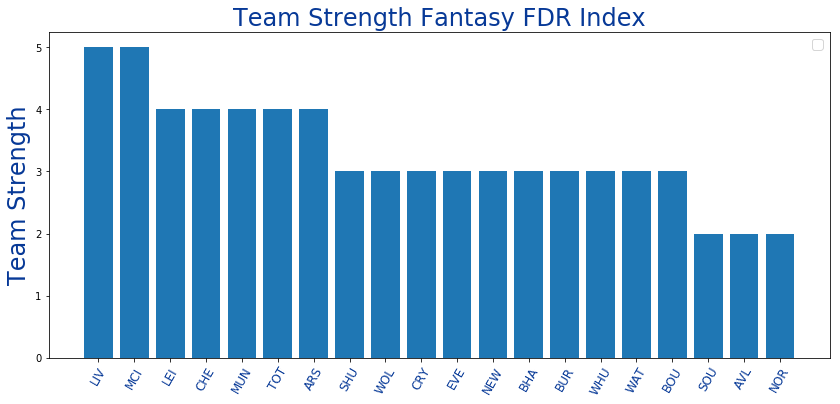

In [268]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# from pylab import rcParams
# rcParams['figure.figsize'] = 14, 6

sorted_data = sorted(scores.items(), key = lambda x: x[1], reverse = True)

Team = [item[0] for item in sorted_data]
strength = [item[1] for item in sorted_data]

plt.bar(Team, strength)
plt.ylabel('Team Strength', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Team Strength Fantasy FDR Index', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

In [269]:
maybs

[5.428571428571429,
 4.694577899794098,
 4.153250318658692,
 3.000849756512076,
 2.9032911723371573,
 2.5048207340588946,
 2.3439879726770596,
 2.345981632186162,
 1.993136582017845,
 1.9275419158741054,
 1.672549596365657,
 1.3161747883779455,
 1.2679347648462271,
 1.631369088472726,
 1.132137137627872,
 1.3527143183972288,
 1.0501029512697326,
 0.8078569794424293,
 0.9004804392587512,
 0.09523809523809512]

In [270]:
new_FDR =  list(zip(name_list, maybs))

In [271]:
new_FDR

[('LIV', 5.428571428571429),
 ('MCI', 4.694577899794098),
 ('LEI', 4.153250318658692),
 ('CHE', 3.000849756512076),
 ('MUN', 2.9032911723371573),
 ('SHU', 2.5048207340588946),
 ('WOL', 2.3439879726770596),
 ('TOT', 2.345981632186162),
 ('CRY', 1.993136582017845),
 ('ARS', 1.9275419158741054),
 ('EVE', 1.672549596365657),
 ('SOU', 1.3161747883779455),
 ('NEW', 1.2679347648462271),
 ('BHA', 1.631369088472726),
 ('BUR', 1.132137137627872),
 ('WHU', 1.3527143183972288),
 ('WAT', 1.0501029512697326),
 ('AVL', 0.8078569794424293),
 ('BOU', 0.9004804392587512),
 ('NOR', 0.09523809523809512)]

In [272]:
def get_avg_FDR(sorted_data, new_FDR):
    listy = []
    for item in sorted_data:
        for score in new_FDR:
            if item[0] == score[0]:
                team = item[0]
                avg_FDR = np.round((item[1] + score[1])/2, 2)
                tup = (team, avg_FDR)
                listy.append(tup)
    return listy
    

In [273]:
final_avg_FDR = get_avg_FDR(sorted_data, new_FDR)

In [274]:
final_avg_FDR = sorted(final_avg_FDR, key = lambda x: x[1], reverse = True)
final_avg_FDR

[('LIV', 5.21),
 ('MCI', 4.85),
 ('LEI', 4.08),
 ('CHE', 3.5),
 ('MUN', 3.45),
 ('TOT', 3.17),
 ('ARS', 2.96),
 ('SHU', 2.75),
 ('WOL', 2.67),
 ('CRY', 2.5),
 ('EVE', 2.34),
 ('BHA', 2.32),
 ('WHU', 2.18),
 ('NEW', 2.13),
 ('BUR', 2.07),
 ('WAT', 2.03),
 ('BOU', 1.95),
 ('SOU', 1.66),
 ('AVL', 1.4),
 ('NOR', 1.05)]

In [275]:
adjusted_FDR = dict(final_avg_FDR)

In [276]:
adjusted_FDR

{'LIV': 5.21,
 'MCI': 4.85,
 'LEI': 4.08,
 'CHE': 3.5,
 'MUN': 3.45,
 'TOT': 3.17,
 'ARS': 2.96,
 'SHU': 2.75,
 'WOL': 2.67,
 'CRY': 2.5,
 'EVE': 2.34,
 'BHA': 2.32,
 'WHU': 2.18,
 'NEW': 2.13,
 'BUR': 2.07,
 'WAT': 2.03,
 'BOU': 1.95,
 'SOU': 1.66,
 'AVL': 1.4,
 'NOR': 1.05}

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(*args, **kw)>

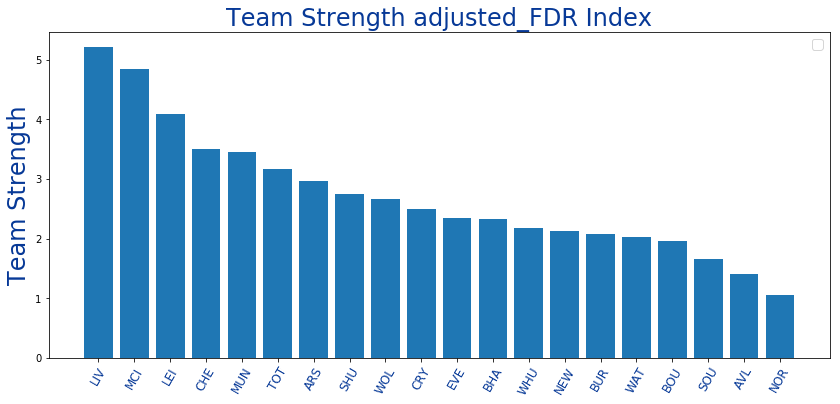

In [277]:
Team = [item[0] for item in final_avg_FDR]
strength = [item[1] for item in final_avg_FDR]

plt.bar(Team, strength)
plt.ylabel('Team Strength', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Team Strength adjusted_FDR Index', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

In [278]:
schedule_df.columns

Index(['Arsenal', 'Aston Villa', 'Bournemouth', 'Brighton', 'Burnley',
       'Chelsea', 'Crystal Palace', 'Everton', 'Leicester', 'Liverpool',
       'Man City', 'Man Utd', 'Newcastle', 'Norwich', 'Sheffield Utd',
       'Southampton', 'Spurs', 'Watford', 'West Ham', 'Wolves'],
      dtype='object')

In [279]:
schedule_df.head(10)

,Arsenal,Aston Villa,Bournemouth,Brighton,Burnley,Chelsea,Crystal Palace,Everton,Leicester,Liverpool,Man City,Man Utd,Newcastle,Norwich,Sheffield Utd,Southampton,Spurs,Watford,West Ham,Wolves
Gameweek,,,,,,,,,,,,,,,,,,,,
0,NEW,TOT,SHU,WAT,SOU,MUN,EVE,CRY,WOL,NOR,WHU,CHE,ARS,LIV,BOU,BUR,AVL,BHA,MCI,LEI
1,BUR,BOU,AVL,WHU,ARS,LEI,SHU,WAT,CHE,SOU,TOT,WOL,NOR,NEW,CRY,LIV,MCI,EVE,BHA,MUN
2,LIV,EVE,MCI,SOU,WOL,NOR,MUN,AVL,SHU,ARS,BOU,CRY,TOT,CHE,LEI,BHA,NEW,WHU,WAT,BUR
3,TOT,CRY,LEI,MCI,LIV,SHU,AVL,WOL,BOU,BUR,BHA,SOU,WAT,WHU,CHE,MUN,ARS,NEW,NOR,EVE
4,WAT,WHU,EVE,BUR,BHA,WOL,TOT,BOU,MUN,NEW,NOR,LEI,LIV,MCI,SOU,SHU,CRY,ARS,AVL,CHE
5,AVL,ARS,SOU,NEW,NOR,LIV,WOL,SHU,TOT,CHE,WAT,WHU,BHA,BUR,EVE,BOU,LEI,MCI,MUN,CRY
6,MUN,BUR,WHU,CHE,AVL,BHA,NOR,MCI,NEW,SHU,EVE,ARS,LEI,CRY,LIV,TOT,SOU,WOL,BOU,WAT
7,BOU,NOR,ARS,TOT,EVE,SOU,WHU,BUR,LIV,LEI,WOL,NEW,MUN,AVL,WAT,CHE,BHA,SHU,CRY,MCI
8,SHU,BHA,NOR,AVL,LEI,NEW,MCI,WHU,BUR,MUN,CRY,LIV,CHE,BOU,ARS,WOL,WAT,TOT,EVE,SOU


In [280]:
def avg_FDR(scores = adjusted_FDR, week = gameweek, periods = next_n_games):
    dic = {}
    for team in schedule_df.columns:
        oponents = schedule_df[team][(week-1):(week+periods)]
        avg_FDR = round(sum([scores[oponent] for oponent in oponents])/len(oponents), 2)
        dic[team] = avg_FDR
    return dic

In [281]:
calculate_FDR = avg_FDR()

In [282]:
sorted_FDR = sorted(calculate_FDR.items(), key=lambda x: x[1], reverse=True)

In [283]:
sorted_FDR

[('Burnley', 3.5),
 ('Southampton', 3.46),
 ('Sheffield Utd', 3.44),
 ('Wolves', 3.44),
 ('Man Utd', 3.32),
 ('Crystal Palace', 3.09),
 ('Chelsea', 3.06),
 ('West Ham', 2.91),
 ('Man City', 2.81),
 ('Arsenal', 2.77),
 ('Spurs', 2.64),
 ('Liverpool', 2.59),
 ('Leicester', 2.58),
 ('Norwich', 2.42),
 ('Newcastle', 2.3),
 ('Watford', 2.3),
 ('Everton', 2.11),
 ('Aston Villa', 2.1),
 ('Brighton', 1.84),
 ('Bournemouth', 1.59)]

<function matplotlib.pyplot.show(*args, **kw)>

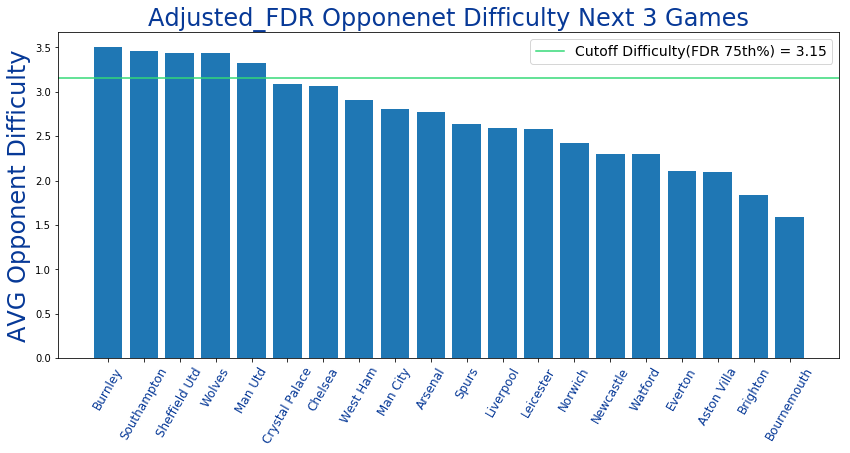

In [284]:
rcParams['figure.figsize'] = 14, 6

Team = [item[0] for item in sorted_FDR]
FDR = [item[1] for item in sorted_FDR]

FDR_75 = round(np.percentile([item[1] for item in sorted_FDR], 75), 2)
cutoff = FDR_75

plt.bar(Team, FDR)
plt.axhline(y=cutoff, linestyle='-', color='#33D977', label='Cutoff Difficulty(FDR 75th%) = ' + str(cutoff))
plt.ylabel('AVG Opponent Difficulty', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Adjusted_FDR Opponenet Difficulty Next ' + str(next_n_games +1) + ' Games', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('FDR', bbox_inches = 'tight')
plt.show

## Clean final list of available players by FDR score <= 3.56 and status = 'available'

In [285]:
player_df.head()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
422,12,5.1,1837,John Lundstram,Defender,5.09,0,20.39,available,49,Sheffield Utd,104,3407217,698233
419,7,5.1,1980,George Baldock,Defender,4.41,0,19.02,available,49,Sheffield Utd,97,1032901,246229
450,27,6.8,1526,Danny Ings,Forward,7.25,0,18.09,available,20,Southampton,123,2260695,628570
522,13,4.9,1980,Ben Foster,Goalkeeper,3.95,0,17.76,available,57,Watford,87,243015,180011
435,5,4.9,1890,Dean Henderson,Goalkeeper,4.14,0,17.76,available,49,Sheffield Utd,87,920704,341652


In [286]:
player_df.shape

(603, 14)

In [287]:
clean_df = player_df[player_df.status == 'available']

In [288]:
clean_df.status.value_counts()

available    434
Name: status, dtype: int64

## Remove teams with FDR scores > 3.56 from DF - optional

In [289]:
teams_low_FDR = [key for (key,value) in calculate_FDR.items() if value <= cutoff]

In [290]:
teams_low_FDR

['Arsenal',
 'Aston Villa',
 'Bournemouth',
 'Brighton',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Leicester',
 'Liverpool',
 'Man City',
 'Newcastle',
 'Norwich',
 'Spurs',
 'Watford',
 'West Ham']

In [291]:
clean_df.head()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
422,12,5.1,1837,John Lundstram,Defender,5.09,0,20.39,available,49,Sheffield Utd,104,3407217,698233
419,7,5.1,1980,George Baldock,Defender,4.41,0,19.02,available,49,Sheffield Utd,97,1032901,246229
450,27,6.8,1526,Danny Ings,Forward,7.25,0,18.09,available,20,Southampton,123,2260695,628570
522,13,4.9,1980,Ben Foster,Goalkeeper,3.95,0,17.76,available,57,Watford,87,243015,180011
435,5,4.9,1890,Dean Henderson,Goalkeeper,4.14,0,17.76,available,49,Sheffield Utd,87,920704,341652


In [292]:
final_df = clean_df.loc[clean_df.team_name.isin(teams_low_FDR)]

In [293]:
final_df.head(15)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
522,13,4.9,1980,Ben Foster,Goalkeeper,3.95,0,17.76,available,57,Watford,87,243015,180011
400,10,4.9,1536,Todd Cantwell,Midfielder,5.04,0,17.55,available,45,Norwich,86,3253867,1682476
104,11,4.9,1980,Mathew Ryan,Goalkeeper,3.82,0,17.14,available,36,Brighton,84,1062059,646861
199,17,5.0,1752,Jordan Ayew,Forward,4.26,0,16.60,available,31,Crystal Palace,83,1212069,957124
240,7,5.3,1944,Jonny Evans,Defender,4.03,0,16.42,available,13,Leicester,87,651206,254407
246,3,5.4,1980,Kasper Schmeichel,Goalkeeper,4.00,0,16.30,available,13,Leicester,88,1102747,471754
363,5,5.0,1980,Martin Dubravka,Goalkeeper,3.68,0,16.20,available,4,Newcastle,81,91839,80033
242,8,5.1,1890,Çaglar Söyüncü,Defender,3.90,0,16.08,available,13,Leicester,82,1895077,594765
187,10,5.1,1800,Vicente Guaita,Goalkeeper,4.10,0,16.08,available,31,Crystal Palace,82,312805,168734
99,11,4.8,1800,Lewis Dunk,Defender,3.80,0,15.83,available,36,Brighton,76,1227793,763913


In [294]:
clean_players = final_df.to_dict('records')

In [295]:
clean_players[:2]

[{'bonus': 13,
  'cost': 4.9,
  'minutes': 1980,
  'name': 'Ben Foster',
  'position': 'Goalkeeper',
  'pts_per_90min': 3.95,
  'red_cards': 0,
  'roi': 17.76,
  'status': 'available',
  'team_code': 57,
  'team_name': 'Watford',
  'total_points': 87,
  'transfers_in': 243015,
  'transfers_out': 180011},
 {'bonus': 10,
  'cost': 4.9,
  'minutes': 1536,
  'name': 'Todd Cantwell',
  'position': 'Midfielder',
  'pts_per_90min': 5.04,
  'red_cards': 0,
  'roi': 17.55,
  'status': 'available',
  'team_code': 45,
  'team_name': 'Norwich',
  'total_points': 86,
  'transfers_in': 3253867,
  'transfers_out': 1682476}]

## Get list of players by ROI, Total Points and Points Per 90 min

In [296]:
players_roi = sorted(clean_players, key = lambda x: x['roi'], reverse = True)

In [297]:
players_roi[:3]

[{'bonus': 13,
  'cost': 4.9,
  'minutes': 1980,
  'name': 'Ben Foster',
  'position': 'Goalkeeper',
  'pts_per_90min': 3.95,
  'red_cards': 0,
  'roi': 17.76,
  'status': 'available',
  'team_code': 57,
  'team_name': 'Watford',
  'total_points': 87,
  'transfers_in': 243015,
  'transfers_out': 180011},
 {'bonus': 10,
  'cost': 4.9,
  'minutes': 1536,
  'name': 'Todd Cantwell',
  'position': 'Midfielder',
  'pts_per_90min': 5.04,
  'red_cards': 0,
  'roi': 17.55,
  'status': 'available',
  'team_code': 45,
  'team_name': 'Norwich',
  'total_points': 86,
  'transfers_in': 3253867,
  'transfers_out': 1682476},
 {'bonus': 11,
  'cost': 4.9,
  'minutes': 1980,
  'name': 'Mathew Ryan',
  'position': 'Goalkeeper',
  'pts_per_90min': 3.82,
  'red_cards': 0,
  'roi': 17.14,
  'status': 'available',
  'team_code': 36,
  'team_name': 'Brighton',
  'total_points': 84,
  'transfers_in': 1062059,
  'transfers_out': 646861}]

### Total Points

In [298]:
players_max_pts = sorted(players_roi, key = lambda x: x['total_points'], reverse = True)

In [299]:
players_max_pts[:3]

[{'bonus': 19,
  'cost': 10.7,
  'minutes': 1710,
  'name': 'Kevin De Bruyne',
  'position': 'Midfielder',
  'pts_per_90min': 7.89,
  'red_cards': 0,
  'roi': 14.02,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 150,
  'transfers_in': 4570118,
  'transfers_out': 2189993},
 {'bonus': 25,
  'cost': 10.1,
  'minutes': 1800,
  'name': 'Jamie Vardy',
  'position': 'Forward',
  'pts_per_90min': 7.45,
  'red_cards': 0,
  'roi': 14.75,
  'status': 'available',
  'team_code': 13,
  'team_name': 'Leicester',
  'total_points': 149,
  'transfers_in': 3922768,
  'transfers_out': 1140000},
 {'bonus': 18,
  'cost': 12.4,
  'minutes': 1663,
  'name': 'Sadio Mané',
  'position': 'Midfielder',
  'pts_per_90min': 7.73,
  'red_cards': 0,
  'roi': 11.53,
  'status': 'available',
  'team_code': 14,
  'team_name': 'Liverpool',
  'total_points': 143,
  'transfers_in': 3381313,
  'transfers_out': 1683235}]

### Per 90 mins played

In [300]:
players_90min = sorted(players_roi, key = lambda x: x['pts_per_90min'], reverse = True)

#define filter of minimum time played
min_min = min_min
players_90min = [player for player in players_90min if player['minutes'] >= min_min]

In [301]:
players_90min[:3]

[{'bonus': 11,
  'cost': 11.8,
  'minutes': 994,
  'name': 'Sergio Agüero',
  'position': 'Forward',
  'pts_per_90min': 9.23,
  'red_cards': 0,
  'roi': 8.64,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 102,
  'transfers_in': 1717412,
  'transfers_out': 2121241},
 {'bonus': 12,
  'cost': 8.5,
  'minutes': 1083,
  'name': 'Riyad Mahrez',
  'position': 'Midfielder',
  'pts_per_90min': 8.8,
  'red_cards': 0,
  'roi': 12.47,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 106,
  'transfers_in': 1226358,
  'transfers_out': 937025},
 {'bonus': 19,
  'cost': 10.7,
  'minutes': 1710,
  'name': 'Kevin De Bruyne',
  'position': 'Midfielder',
  'pts_per_90min': 7.89,
  'red_cards': 0,
  'roi': 14.02,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 150,
  'transfers_in': 4570118,
  'transfers_out': 2189993}]

### Create player lists by position and metric we want to select by

In [302]:
GK_roi = [item for item in players_roi if item['position'] == 'Goalkeeper']
DF_roi = [item for item in players_roi if item['position'] == 'Defender']
MD_roi = [item for item in players_roi if item['position'] == 'Midfielder']
ST_roi = [item for item in players_roi if item['position'] == 'Forward']

In [303]:
GK_pts = [item for item in players_max_pts if item['position'] == 'Goalkeeper']
DF_pts = [item for item in players_max_pts if item['position'] == 'Defender']
MD_pts = [item for item in players_max_pts if item['position'] == 'Midfielder']
ST_pts = [item for item in players_max_pts if item['position'] == 'Forward']

In [304]:
GK_90min = [item for item in players_90min if item['position'] == 'Goalkeeper']
DF_90min = [item for item in players_90min if item['position'] == 'Defender']
MD_90min = [item for item in players_90min if item['position'] == 'Midfielder']
ST_90min = [item for item in players_90min if item['position'] == 'Forward']

## Start by selecting top GKs by ROI

In [305]:
#define money team as empty list and list that tracks count of players selectd per team
money_team = []
players_selected = []
teams_selected = []

#Instantiate initial count per position
#Current players selected for each position
DF_curr = 0
MD_curr = 0 
ST_curr = 0

GK_budget = budget*GK_coef
print(GK_budget)

for item in GK_roi:
    if item['cost'] <= 5.5 and item['cost'] <= GK_budget:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        GK_budget -= item['cost']
        print('Player Selected: ' + item['name'])
        print('GK budget left: ' + str(GK_budget))

print(players_selected)
print(teams_selected)

9.5
Player Selected: Ben Foster
GK budget left: 4.6
Player Selected: Tim Krul
GK budget left: 0.09999999999999964
['Ben Foster', 'Tim Krul']
['Watford', 'Norwich']


## Select Top player by points from DF, MD, ST

In [306]:
DF_budget = budget*DF_coef + GK_budget
MD_budget = budget*MD_coef
ST_budget = budget*ST_coef

print(DF_budget, MD_budget, ST_budget)

#Select Top Defender
money_team.append(DF_pts[0])
players_selected.append(DF_pts[0]['name'])
teams_selected.append(DF_pts[0]['team_name'])
DF_budget -= DF_pts[0]['cost']
DF_curr += 1
print('Player Selected: ' + DF_pts[0]['name'])
print('DF budget left: ' + str(DF_budget))

#Select Top Midfielder
money_team.append(MD_pts[0])
players_selected.append(MD_pts[0]['name'])
teams_selected.append(MD_pts[0]['team_name'])
MD_budget -= MD_pts[0]['cost']
MD_curr += 1
print('Player Selected: ' + MD_pts[0]['name'])
print('MD budget left: ' + str(MD_budget))


print(players_selected)
print(teams_selected)

28.599999999999994 36.0 26.0
Player Selected: Trent Alexander-Arnold
DF budget left: 21.099999999999994
Player Selected: Kevin De Bruyne
MD budget left: 25.3
['Ben Foster', 'Tim Krul', 'Trent Alexander-Arnold', 'Kevin De Bruyne']
['Watford', 'Norwich', 'Liverpool', 'Man City']


In [307]:
ST_pts[:3]

[{'bonus': 25,
  'cost': 10.1,
  'minutes': 1800,
  'name': 'Jamie Vardy',
  'position': 'Forward',
  'pts_per_90min': 7.45,
  'red_cards': 0,
  'roi': 14.75,
  'status': 'available',
  'team_code': 13,
  'team_name': 'Leicester',
  'total_points': 149,
  'transfers_in': 3922768,
  'transfers_out': 1140000},
 {'bonus': 20,
  'cost': 7.8,
  'minutes': 1660,
  'name': 'Tammy Abraham',
  'position': 'Forward',
  'pts_per_90min': 6.56,
  'red_cards': 0,
  'roi': 15.51,
  'status': 'available',
  'team_code': 8,
  'team_name': 'Chelsea',
  'total_points': 121,
  'transfers_in': 5092274,
  'transfers_out': 3075514},
 {'bonus': 11,
  'cost': 11.8,
  'minutes': 994,
  'name': 'Sergio Agüero',
  'position': 'Forward',
  'pts_per_90min': 9.23,
  'red_cards': 0,
  'roi': 8.64,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 102,
  'transfers_in': 1717412,
  'transfers_out': 2121241}]

In [308]:
#Select Top Striker

for item in ST_pts[:3]:
    if teams_selected.count(item['team_name']) < 3 and len(money_team) == 4:
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
    break

print(len(money_team))
print(players_selected)
print(teams_selected)

Player Selected: Jamie Vardy
ST budget left: 15.9
5
['Ben Foster', 'Tim Krul', 'Trent Alexander-Arnold', 'Kevin De Bruyne', 'Jamie Vardy']
['Watford', 'Norwich', 'Liverpool', 'Man City', 'Leicester']


In [309]:
print(DF_curr, MD_curr, ST_curr)

1 1 1


In [310]:
print(DF, MD, ST)

3 4 3


### Fill rest of team with top ROI players

In [311]:
for item in DF_roi:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < DF_budget and DF_curr < DF:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        DF_budget -= item['cost']
        DF_curr += 1
        print('Player Selected: ' + item['name'])
        print('DF budget left: ' + str(DF_budget))
        print('# of DFs selected: ' + str(DF_curr))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and DF_max != DF_curr and item['cost'] <= DF_budget / (DF_max - DF_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            DF_budget -= item['cost']
            DF_curr += 1
            print('Player Selected: ' + item['name'])
            print('DF budget left: ' + str(DF_budget))
            print('# of DFs selected: ' + str(DF_curr))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected)                       

Player Selected: Jonny Evans
DF budget left: 15.799999999999994
# of DFs selected: 2
Player Selected: Çaglar Söyüncü
DF budget left: 10.699999999999994
# of DFs selected: 3
Player Selected: Lewis Dunk
DF budget left: 5.899999999999994
# of DFs selected: 4
Player Selected: Martin Kelly
DF budget left: 1.4999999999999938
# of DFs selected: 5
9
['Ben Foster', 'Tim Krul', 'Trent Alexander-Arnold', 'Kevin De Bruyne', 'Jamie Vardy', 'Jonny Evans', 'Çaglar Söyüncü', 'Lewis Dunk', 'Martin Kelly']
['Watford', 'Norwich', 'Liverpool', 'Man City', 'Leicester', 'Leicester', 'Leicester', 'Brighton', 'Crystal Palace']


## Fill MD position

In [312]:
#move leftover DF budget to MD budget
MD_budget += DF_budget

for item in MD_roi:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < MD_budget and MD_curr < MD:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        MD_budget -= item['cost']
        MD_curr += 1
        print('Player Selected: ' + item['name'])
        print('MD budget left: ' + str(MD_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and MD_max != MD_curr and item['cost'] <= MD_budget / (MD_max - MD_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            MD_budget -= item['cost']
            MD_curr += 1
            print('Player Selected: ' + item['name'])
            print('MD budget left: ' + str(MD_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Todd Cantwell
MD budget left: 21.89999999999999
Player Selected: Jack Grealish
MD budget left: 15.399999999999991
Player Selected: Mason Mount
MD budget left: 9.199999999999992
Player Selected: Richarlison de Andrade
MD budget left: 1.0999999999999925
13
['Ben Foster', 'Tim Krul', 'Trent Alexander-Arnold', 'Kevin De Bruyne', 'Jamie Vardy', 'Jonny Evans', 'Çaglar Söyüncü', 'Lewis Dunk', 'Martin Kelly', 'Todd Cantwell', 'Jack Grealish', 'Mason Mount', 'Richarlison de Andrade']
['Watford', 'Norwich', 'Liverpool', 'Man City', 'Leicester', 'Leicester', 'Leicester', 'Brighton', 'Crystal Palace', 'Norwich', 'Aston Villa', 'Chelsea', 'Everton']


## Fill ST position

In [313]:
#move leftover MD budget to ST budget
ST_budget += MD_budget

for item in ST_roi:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < ST_budget and ST_curr < ST:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        ST_budget -= item['cost']
        ST_curr += 1
        print('Player Selected: ' + item['name'])
        print('ST budget left: ' + str(ST_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and ST_max != ST_curr and item['cost'] <= ST_budget / (ST_max - ST_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Jordan Ayew
ST budget left: 11.999999999999993
Player Selected: Tammy Abraham
ST budget left: 4.199999999999993
15
['Ben Foster', 'Tim Krul', 'Trent Alexander-Arnold', 'Kevin De Bruyne', 'Jamie Vardy', 'Jonny Evans', 'Çaglar Söyüncü', 'Lewis Dunk', 'Martin Kelly', 'Todd Cantwell', 'Jack Grealish', 'Mason Mount', 'Richarlison de Andrade', 'Jordan Ayew', 'Tammy Abraham']
['Watford', 'Norwich', 'Liverpool', 'Man City', 'Leicester', 'Leicester', 'Leicester', 'Brighton', 'Crystal Palace', 'Norwich', 'Aston Villa', 'Chelsea', 'Everton', 'Crystal Palace', 'Chelsea']


In [314]:
money_df = pd.DataFrame(money_team)

In [315]:
money_df

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,13,4.9,1980,Ben Foster,Goalkeeper,3.95,0,17.76,available,57,Watford,87,243015,180011
1,6,4.5,1800,Tim Krul,Goalkeeper,2.90,0,12.89,available,45,Norwich,58,187347,135805
2,12,7.5,1842,Trent Alexander-Arnold,Defender,5.76,0,15.73,available,14,Liverpool,118,2219095,1162411
3,19,10.7,1710,Kevin De Bruyne,Midfielder,7.89,0,14.02,available,43,Man City,150,4570118,2189993
4,25,10.1,1800,Jamie Vardy,Forward,7.45,0,14.75,available,13,Leicester,149,3922768,1140000
5,7,5.3,1944,Jonny Evans,Defender,4.03,0,16.42,available,13,Leicester,87,651206,254407
6,8,5.1,1890,Çaglar Söyüncü,Defender,3.90,0,16.08,available,13,Leicester,82,1895077,594765
7,11,4.8,1800,Lewis Dunk,Defender,3.80,0,15.83,available,36,Brighton,76,1227793,763913
8,4,4.4,1396,Martin Kelly,Defender,3.99,0,14.09,available,31,Crystal Palace,62,1790080,1172336
9,10,4.9,1536,Todd Cantwell,Midfielder,5.04,0,17.55,available,45,Norwich,86,3253867,1682476


<function matplotlib.pyplot.show(*args, **kw)>

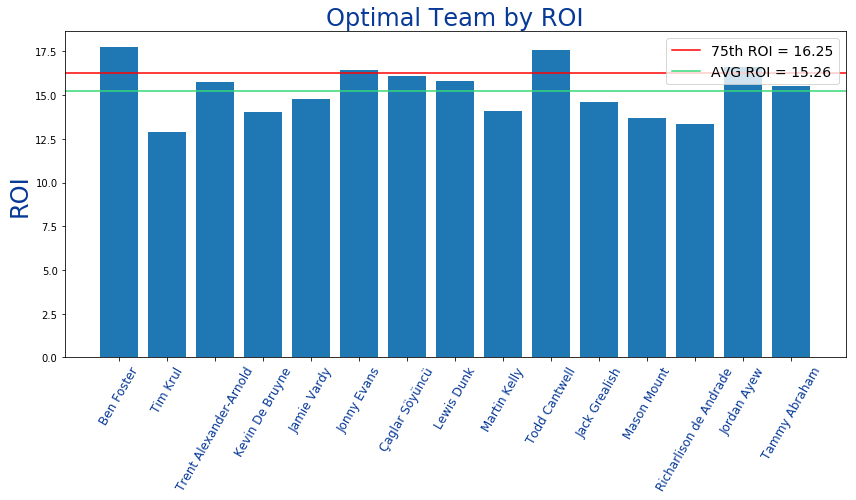

In [316]:
money_x = money_df.roi
money_y = money_df.name
ST_75th = round(money_df.describe().roi['75%'], 2)
ST_AVG = round(money_df.describe().roi['mean'], 2)

plt.bar(money_y, money_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th ROI = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG ROI = ' + str(ST_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Optimal Team by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

### Top 10 ROI players by position

In [317]:
GK_df = pd.DataFrame(GK_roi)
GK_df.head(10)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,13,4.9,1980,Ben Foster,Goalkeeper,3.95,0,17.76,available,57,Watford,87,243015,180011
1,11,4.9,1980,Mathew Ryan,Goalkeeper,3.82,0,17.14,available,36,Brighton,84,1062059,646861
2,3,5.4,1980,Kasper Schmeichel,Goalkeeper,4.00,0,16.30,available,13,Leicester,88,1102747,471754
3,5,5.0,1980,Martin Dubravka,Goalkeeper,3.68,0,16.20,available,4,Newcastle,81,91839,80033
4,10,5.1,1800,Vicente Guaita,Goalkeeper,4.10,0,16.08,available,31,Crystal Palace,82,312805,168734
5,5,5.0,1980,Bernd Leno,Goalkeeper,3.50,0,15.40,available,3,Arsenal,77,398062,438768
6,3,5.3,1980,Jordan Pickford,Goalkeeper,3.23,0,13.40,available,11,Everton,71,451466,632081
7,6,4.5,1800,Tim Krul,Goalkeeper,2.90,0,12.89,available,45,Norwich,58,187347,135805
8,0,5.5,1980,Kepa Arrizabalaga,Goalkeeper,2.73,0,10.91,available,8,Chelsea,60,333810,379334
9,2,6.0,1631,Ederson Santana de Moraes,Goalkeeper,3.25,1,9.83,available,43,Man City,59,851641,1377034


In [318]:
DF_df = pd.DataFrame(DF_roi)
DF_df.head(10)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,7,5.3,1944,Jonny Evans,Defender,4.03,0,16.42,available,13,Leicester,87,651206,254407
1,8,5.1,1890,Çaglar Söyüncü,Defender,3.90,0,16.08,available,13,Leicester,82,1895077,594765
2,11,4.8,1800,Lewis Dunk,Defender,3.80,0,15.83,available,36,Brighton,76,1227793,763913
3,12,7.5,1842,Trent Alexander-Arnold,Defender,5.76,0,15.73,available,14,Liverpool,118,2219095,1162411
4,8,6.4,1890,Virgil van Dijk,Defender,4.66,0,15.31,available,14,Liverpool,98,1158774,1972889
5,12,7.0,1813,Andrew Robertson,Defender,5.16,0,14.86,available,14,Liverpool,104,1003881,1719475
6,10,6.4,1890,Ricardo Domingos Barbosa Pereira,Defender,4.43,0,14.53,available,13,Leicester,93,1331949,785843
7,4,4.4,1396,Martin Kelly,Defender,3.99,0,14.09,available,31,Crystal Palace,62,1790080,1172336
8,3,4.3,1723,Craig Cathcart,Defender,3.08,0,13.72,available,57,Watford,59,117524,227829
9,6,4.6,1481,Jetro Willems,Defender,3.83,0,13.70,available,4,Newcastle,63,360913,233475


In [319]:
MD_df = pd.DataFrame(MD_roi)
MD_df.head(10)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,10,4.9,1536,Todd Cantwell,Midfielder,5.04,0,17.55,available,45,Norwich,86,3253867,1682476
1,11,6.5,1793,Jack Grealish,Midfielder,4.77,0,14.62,available,7,Aston Villa,95,1734036,768977
2,19,10.7,1710,Kevin De Bruyne,Midfielder,7.89,0,14.02,available,43,Man City,150,4570118,2189993
3,6,6.1,1180,Ayoze Pérez,Midfielder,6.48,0,13.93,available,13,Leicester,85,731704,1311726
4,6,6.2,1801,Mason Mount,Midfielder,4.25,0,13.71,available,8,Chelsea,85,3703096,2669953
5,14,7.7,1769,James Maddison,Midfielder,5.34,0,13.64,available,13,Leicester,105,2626527,1491303
6,10,8.1,1902,Richarlison de Andrade,Midfielder,5.11,0,13.33,available,11,Everton,108,1466176,1139970
7,6,4.9,1513,Jorge Luiz Frello Filho,Midfielder,3.75,0,12.86,available,8,Chelsea,63,485571,533677
8,5,5.0,1429,Mark Noble,Midfielder,4.03,0,12.80,available,21,West Ham,64,132387,101753
9,14,7.2,1540,Willian Borges Da Silva,Midfielder,5.37,0,12.78,available,8,Chelsea,92,791460,420369


In [320]:
ST_df = pd.DataFrame(ST_roi)
ST_df.head(10)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,17,5.0,1752,Jordan Ayew,Forward,4.26,0,16.60,available,31,Crystal Palace,83,1212069,957124
1,20,7.8,1660,Tammy Abraham,Forward,6.56,0,15.51,available,8,Chelsea,121,5092274,3075514
2,25,10.1,1800,Jamie Vardy,Forward,7.45,0,14.75,available,13,Leicester,149,3922768,1140000
3,12,5.9,1626,Neal Maupay,Forward,4.48,0,13.73,available,36,Brighton,81,402022,275819
4,9,5.9,1307,Dominic Calvert-Lewin,Forward,4.82,0,11.86,available,11,Everton,70,655579,287114
5,9,6.1,1625,Gerard Deulofeu,Forward,3.93,0,11.64,available,57,Watford,71,320431,513552
6,17,9.3,1710,Roberto Firmino,Forward,5.26,0,10.75,available,14,Liverpool,100,1117199,1230702
7,8,7.0,1579,Sébastien Haller,Forward,4.22,0,10.57,available,21,West Ham,74,579310,696890
8,4,7.4,1716,Callum Wilson,Forward,3.62,0,9.32,available,91,Bournemouth,69,778972,1634984
9,3,5.5,1678,Joelinton Cássio Apolinário de Lira,Forward,2.68,0,9.09,available,4,Newcastle,50,130495,233617


## Define Clean df for graphing purposes

In [321]:
clean_df.head()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
422,12,5.1,1837,John Lundstram,Defender,5.09,0,20.39,available,49,Sheffield Utd,104,3407217,698233
419,7,5.1,1980,George Baldock,Defender,4.41,0,19.02,available,49,Sheffield Utd,97,1032901,246229
450,27,6.8,1526,Danny Ings,Forward,7.25,0,18.09,available,20,Southampton,123,2260695,628570
522,13,4.9,1980,Ben Foster,Goalkeeper,3.95,0,17.76,available,57,Watford,87,243015,180011
435,5,4.9,1890,Dean Henderson,Goalkeeper,4.14,0,17.76,available,49,Sheffield Utd,87,920704,341652


In [322]:
graph_roi = []
for row, player in clean_df.iterrows():
    playa = dict(name = player['name'], position = player.position, team=player.team_name, cost = player.cost, points = player.total_points, minutes = player.minutes, ROI = player.roi, pts_per_90min = player.pts_per_90min)
    graph_roi.append(playa)

In [323]:
graph_roi[:3]

[{'name': 'John Lundstram',
  'position': 'Defender',
  'team': 'Sheffield Utd',
  'cost': 5.1,
  'points': 104,
  'minutes': 1837,
  'ROI': 20.39,
  'pts_per_90min': 5.09},
 {'name': 'George Baldock',
  'position': 'Defender',
  'team': 'Sheffield Utd',
  'cost': 5.1,
  'points': 97,
  'minutes': 1980,
  'ROI': 19.02,
  'pts_per_90min': 4.41},
 {'name': 'Danny Ings',
  'position': 'Forward',
  'team': 'Southampton',
  'cost': 6.8,
  'points': 123,
  'minutes': 1526,
  'ROI': 18.09,
  'pts_per_90min': 7.25}]

### Graph by ROI

In [324]:
GK_graph = clean_df[clean_df['position'] == 'Goalkeeper']
DF_graph = clean_df[clean_df['position'] == 'Defender']
MD_graph = clean_df[clean_df['position'] == 'Midfielder']
ST_graph = clean_df[clean_df['position'] == 'Forward']

### Graph by 90_min Stat

In [325]:
sorted_players_90min = sorted(graph_roi, key = lambda x: x['pts_per_90min'], reverse = True)

#define filter of minimum time played
min_min = min_min
sorted_players_90min = [player for player in sorted_players_90min if player['minutes'] >= min_min]

In [326]:
sorted_players_90min[:3]

[{'name': 'Sergio Agüero',
  'position': 'Forward',
  'team': 'Man City',
  'cost': 11.8,
  'points': 102,
  'minutes': 994,
  'ROI': 8.64,
  'pts_per_90min': 9.23},
 {'name': 'Riyad Mahrez',
  'position': 'Midfielder',
  'team': 'Man City',
  'cost': 8.5,
  'points': 106,
  'minutes': 1083,
  'ROI': 12.47,
  'pts_per_90min': 8.8},
 {'name': 'Kevin De Bruyne',
  'position': 'Midfielder',
  'team': 'Man City',
  'cost': 10.7,
  'points': 150,
  'minutes': 1710,
  'ROI': 14.02,
  'pts_per_90min': 7.89}]

In [327]:
df_90min = pd.DataFrame(sorted_players_90min)

In [328]:
df_90min.head()

,ROI,cost,minutes,name,points,position,pts_per_90min,team
0,8.64,11.8,994,Sergio Agüero,102,Forward,9.23,Man City
1,12.47,8.5,1083,Riyad Mahrez,106,Midfielder,8.80,Man City
2,14.02,10.7,1710,Kevin De Bruyne,150,Midfielder,7.89,Man City
3,11.53,12.4,1663,Sadio Mané,143,Midfielder,7.73,Liverpool
4,14.75,10.1,1800,Jamie Vardy,149,Forward,7.45,Leicester


In [329]:
GK_90min_graph = df_90min[df_90min['position'] == 'Goalkeeper']
DF_90min_graph = df_90min[df_90min['position'] == 'Defender']
MD_90min_graph = df_90min[df_90min['position'] == 'Midfielder']
ST_90min_graph = df_90min[df_90min['position'] == 'Forward']

In [330]:
GK_90min_graph.head()

,ROI,cost,minutes,name,points,position,pts_per_90min,team
64,8.36,6.1,1103,Alisson Ramses Becker,51,Goalkeeper,4.16,Liverpool
65,17.76,4.9,1890,Dean Henderson,87,Goalkeeper,4.14,Sheffield Utd
69,16.08,5.1,1800,Vicente Guaita,82,Goalkeeper,4.10,Crystal Palace
74,16.30,5.4,1980,Kasper Schmeichel,88,Goalkeeper,4.00,Leicester
77,17.76,4.9,1980,Ben Foster,87,Goalkeeper,3.95,Watford


In [331]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

In [332]:
clean_df.head()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
422,12,5.1,1837,John Lundstram,Defender,5.09,0,20.39,available,49,Sheffield Utd,104,3407217,698233
419,7,5.1,1980,George Baldock,Defender,4.41,0,19.02,available,49,Sheffield Utd,97,1032901,246229
450,27,6.8,1526,Danny Ings,Forward,7.25,0,18.09,available,20,Southampton,123,2260695,628570
522,13,4.9,1980,Ben Foster,Goalkeeper,3.95,0,17.76,available,57,Watford,87,243015,180011
435,5,4.9,1890,Dean Henderson,Goalkeeper,4.14,0,17.76,available,49,Sheffield Utd,87,920704,341652


## Top 50 players ROI

<function matplotlib.pyplot.show(*args, **kw)>

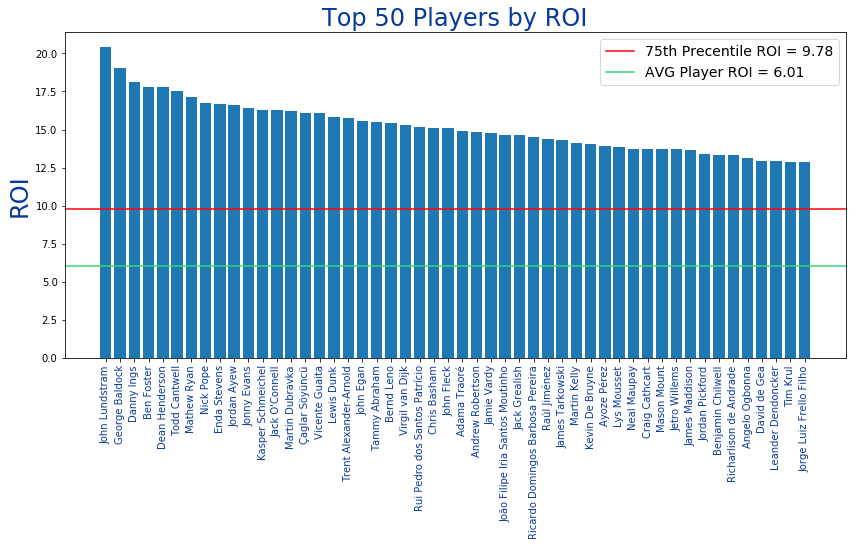

In [333]:
X = clean_df[:50].roi
Y = clean_df[:50].name
DF_75th = round(clean_df.describe().roi['75%'], 2)
DF_AVG = round(clean_df.describe().roi['mean'], 2)

plt.bar(Y, X)
plt.axhline(y=DF_75th, color='r', linestyle='-', label='75th Precentile ROI = ' + str(DF_75th))
plt.axhline(y=DF_AVG, color='#33D977', linestyle='-', label='AVG Player ROI = ' + str(DF_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=90, fontsize =10, color = '#073997')
plt.title('Top 50 Players by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('TOP_50_ROI', bbox_inches = 'tight')
plt.show

## Bottom 50 Players by ROI

<function matplotlib.pyplot.show(*args, **kw)>

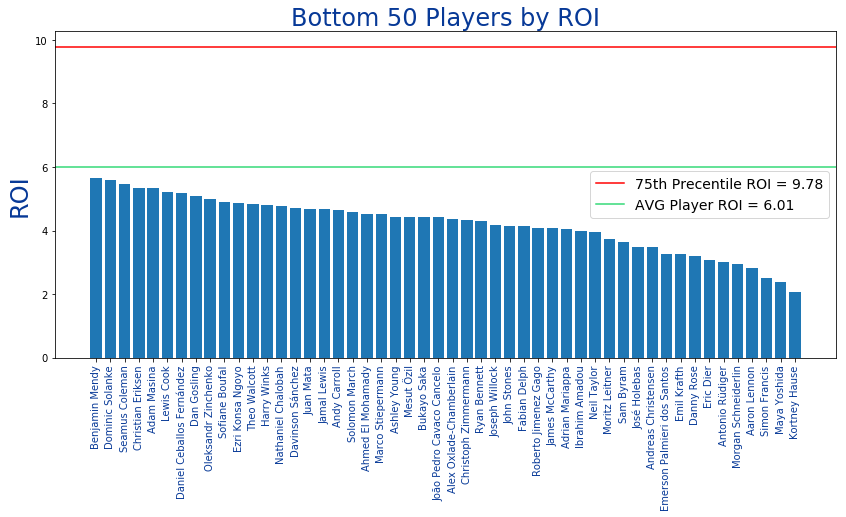

In [334]:
no_zero_roi = clean_df[clean_df.roi >0]
no_zero_roi = no_zero_roi[no_zero_roi.minutes > 460]

X = no_zero_roi[-50:].roi
Y = no_zero_roi[-50:].name
DF_75th = round(clean_df.describe().roi['75%'], 2)
DF_AVG = round(clean_df.describe().roi['mean'], 2)

plt.bar(Y, X)
plt.axhline(y=DF_75th, color='r', linestyle='-', label='75th Precentile ROI = ' + str(DF_75th))
plt.axhline(y=DF_AVG, color='#33D977', linestyle='-', label='AVG Player ROI = ' + str(DF_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=90, fontsize = 10, color = '#073997')
plt.title('Bottom 50 Players by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('Bottom_50_ROI', bbox_inches = 'tight')
plt.show

## Top 10 Keepers ROI

<function matplotlib.pyplot.show(*args, **kw)>

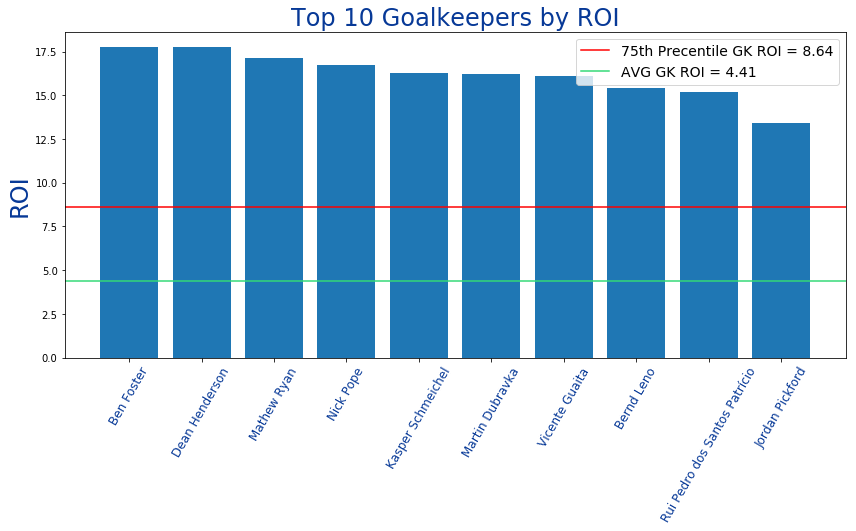

In [335]:
GK_x = GK_graph[:10].roi
GK_y = GK_graph[:10].name
GK_75th = round(GK_graph.describe().roi['75%'], 2)
GK_AVG = round(GK_graph.describe().roi['mean'], 2)

plt.bar(GK_y, GK_x)
plt.axhline(y=GK_75th, color='r', linestyle='-', label='75th Precentile GK ROI = ' + str(GK_75th))
plt.axhline(y=GK_AVG, color='#33D977', linestyle='-', label='AVG GK ROI = ' + str(GK_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Goalkeepers by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('GK_ROI', bbox_inches = 'tight')
plt.show

## Top 10 Keepers 90_min

<function matplotlib.pyplot.show(*args, **kw)>

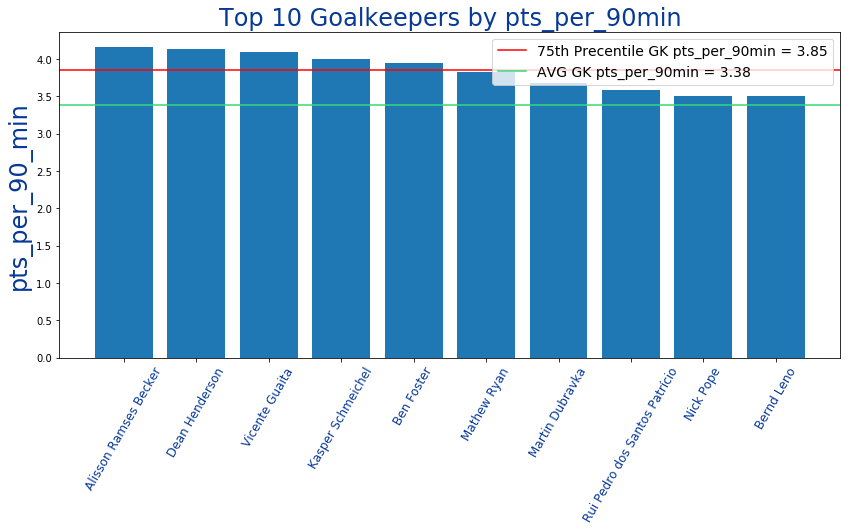

In [336]:
GK_x = GK_90min_graph[:10].pts_per_90min
GK_y = GK_90min_graph[:10].name
GK_75th = round(GK_90min_graph.describe().pts_per_90min['75%'], 2)
GK_AVG = round(GK_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(GK_y, GK_x)
plt.axhline(y=GK_75th, color='r', linestyle='-', label='75th Precentile GK pts_per_90min = ' + str(GK_75th))
plt.axhline(y=GK_AVG, color='#33D977', linestyle='-', label='AVG GK pts_per_90min = ' + str(GK_AVG))
plt.ylabel('pts_per_90_min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Goalkeepers by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('GK_90min', bbox_inches = 'tight')
plt.show

## Top 10 Defenders

<function matplotlib.pyplot.show(*args, **kw)>

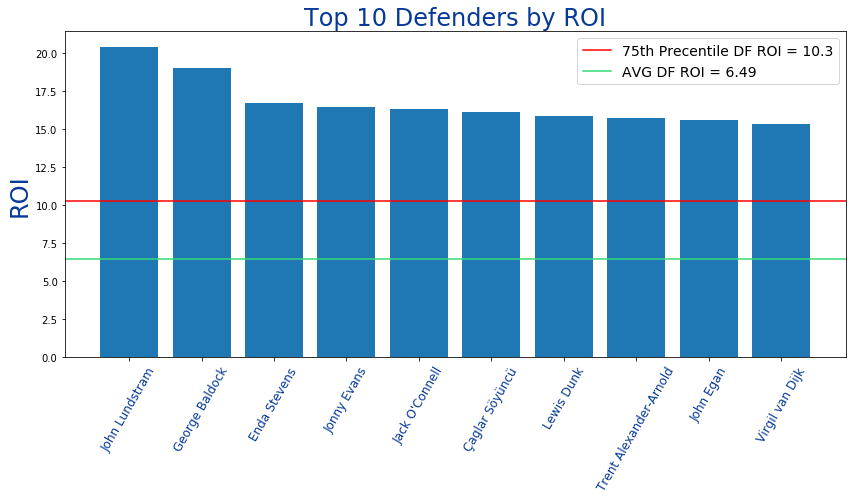

In [337]:
DF_x = DF_graph[:10].roi
DF_y = DF_graph[:10].name
DF_75th = round(DF_graph.describe().roi['75%'], 2)
DF_AVG = round(DF_graph.describe().roi['mean'], 2)

plt.bar(DF_y, DF_x)
plt.axhline(y=DF_75th, color='r', linestyle='-', label='75th Precentile DF ROI = ' + str(DF_75th))
plt.axhline(y=DF_AVG, color='#33D977', linestyle='-', label='AVG DF ROI = ' + str(DF_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Defenders by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('DF_ROI', bbox_inches = 'tight')
plt.show

## Top 10 Defenders 90min Stat

<function matplotlib.pyplot.show(*args, **kw)>

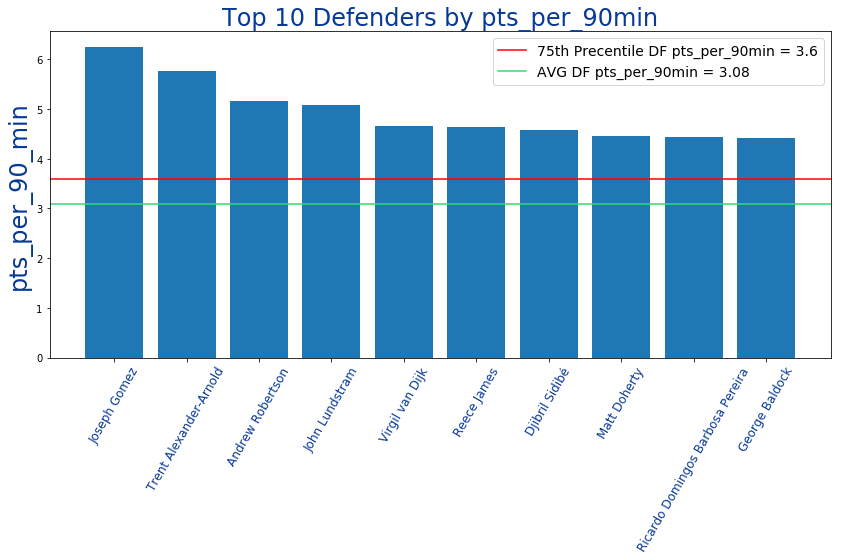

In [338]:
DF_x = DF_90min_graph[:10].pts_per_90min
DF_y = DF_90min_graph[:10].name
DF_75th = round(DF_90min_graph.describe().pts_per_90min['75%'], 2)
DF_AVG = round(DF_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(DF_y, DF_x)
plt.axhline(y=DF_75th, color='r', linestyle='-', label='75th Precentile DF pts_per_90min = ' + str(DF_75th))
plt.axhline(y=DF_AVG, color='#33D977', linestyle='-', label='AVG DF pts_per_90min = ' + str(DF_AVG))
plt.ylabel('pts_per_90_min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Defenders by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('DF_90min', bbox_inches = 'tight')
plt.show

## Top 10 Midfielders

<function matplotlib.pyplot.show(*args, **kw)>

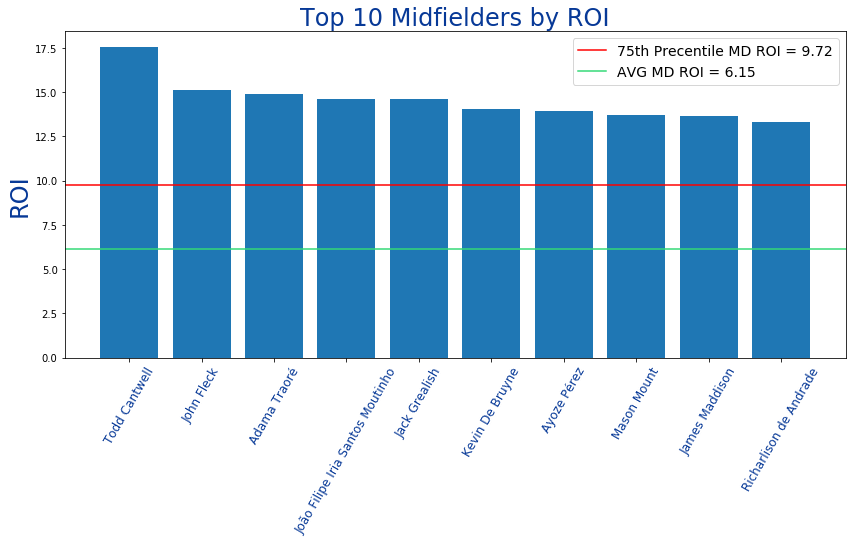

In [339]:
MD_x = MD_graph[:10].roi
MD_y = MD_graph[:10].name
MD_75th = round(MD_graph.describe().roi['75%'], 2)
MD_AVG = round(MD_graph.describe().roi['mean'], 2)

plt.bar(MD_y, MD_x)
plt.axhline(y=MD_75th, color='r', linestyle='-', label='75th Precentile MD ROI = ' + str(MD_75th))
plt.axhline(y=MD_AVG, color='#33D977', linestyle='-', label='AVG MD ROI = ' + str(MD_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Midfielders by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('MD_ROI', bbox_inches = 'tight')
plt.show

## Top 10 Midfielders 90min Stat

<function matplotlib.pyplot.show(*args, **kw)>

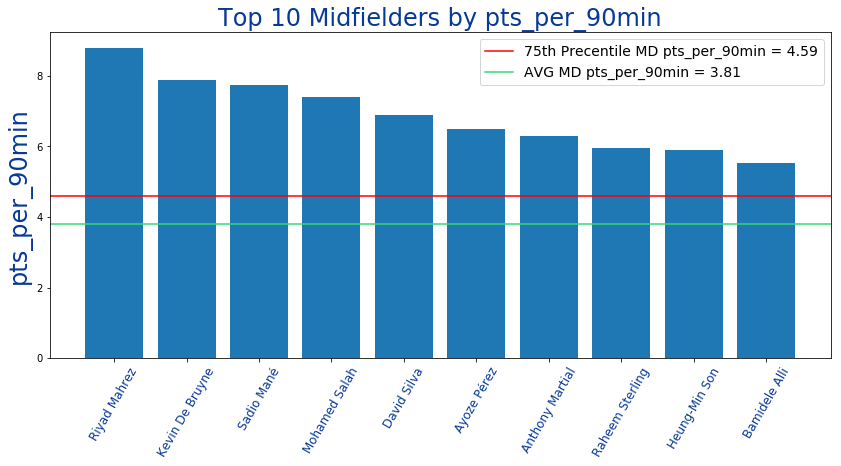

In [340]:
MD_x = MD_90min_graph[:10].pts_per_90min
MD_y = MD_90min_graph[:10].name
MD_75th = round(MD_90min_graph.describe().pts_per_90min['75%'], 2)
MD_AVG = round(MD_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(MD_y, MD_x)
plt.axhline(y=MD_75th, color='r', linestyle='-', label='75th Precentile MD pts_per_90min = ' + str(MD_75th))
plt.axhline(y=MD_AVG, color='#33D977', linestyle='-', label='AVG MD pts_per_90min = ' + str(MD_AVG))
plt.ylabel('pts_per_90min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Midfielders by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('MD_90min', bbox_inches = 'tight')
plt.show

## Top 10 Strikers

<function matplotlib.pyplot.show(*args, **kw)>

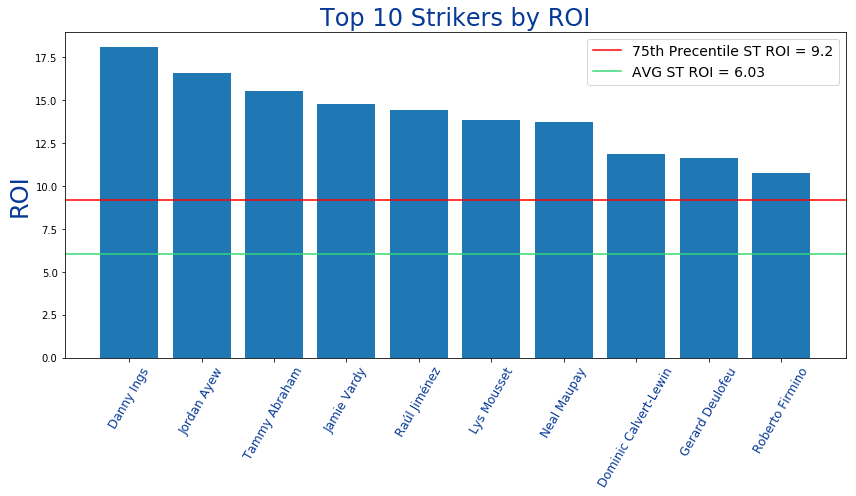

In [341]:
ST_x = ST_graph[:10].roi
ST_y = ST_graph[:10].name
ST_75th = round(ST_graph.describe().roi['75%'], 2)
ST_AVG = round(ST_graph.describe().roi['mean'], 2)

plt.bar(ST_y, ST_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th Precentile ST ROI = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG ST ROI = ' + str(ST_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Strikers by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('ST_ROI', bbox_inches = 'tight')
plt.show

## Top 10 Strikers 90min Stat

<function matplotlib.pyplot.show(*args, **kw)>

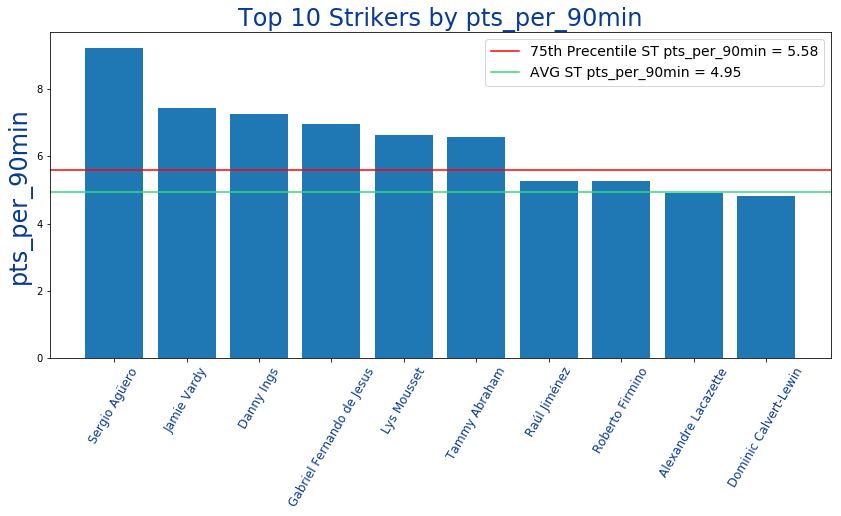

In [342]:
ST_x = ST_90min_graph[:10].pts_per_90min
ST_y = ST_90min_graph[:10].name
ST_75th = round(ST_90min_graph.describe().pts_per_90min['75%'], 2)
ST_AVG = round(ST_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(ST_y, ST_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th Precentile ST pts_per_90min = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG ST pts_per_90min = ' + str(ST_AVG))
plt.ylabel('pts_per_90min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Strikers by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('ST_90min', bbox_inches = 'tight')
plt.show

In [343]:
team_df

,code,strength,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,,,
1,14,5,LIV,Liverpool,21,20,0,1,50,14,+36,61
2,43,5,MCI,Man City,22,15,5,2,62,25,+37,47
3,13,4,LEI,Leicester,22,14,5,3,47,21,+26,45
4,8,4,CHE,Chelsea,22,12,7,3,39,29,+10,39
5,1,4,MUN,Man Utd,22,9,6,7,36,25,+11,34
6,49,3,SHU,Sheffield Utd,22,8,6,8,24,21,+3,32
7,39,3,WOL,Wolves,22,7,5,10,31,28,+3,31
8,6,4,TOT,Spurs,22,8,8,6,36,31,+5,30
9,31,3,CRY,Crystal Palace,22,7,7,8,20,24,-4,29


### Team Stats

In [344]:
teams_stats = team_df.iloc[:,2:12]

In [345]:
teams_stats.GF = [int(item) for item in teams_stats.GF]
teams_stats.GA = [int(item) for item in teams_stats.GA]

In [346]:
teams_stats

,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,
1,LIV,Liverpool,21,20,0,1,50,14,+36,61
2,MCI,Man City,22,15,5,2,62,25,+37,47
3,LEI,Leicester,22,14,5,3,47,21,+26,45
4,CHE,Chelsea,22,12,7,3,39,29,+10,39
5,MUN,Man Utd,22,9,6,7,36,25,+11,34
6,SHU,Sheffield Utd,22,8,6,8,24,21,+3,32
7,WOL,Wolves,22,7,5,10,31,28,+3,31
8,TOT,Spurs,22,8,8,6,36,31,+5,30
9,CRY,Crystal Palace,22,7,7,8,20,24,-4,29


### Worst/ Best  Defence vs. Offence

In [347]:
worst_defence_df = teams_stats.sort_values(by = ['GA'], ascending = False)

In [348]:
worst_defence_df.head()

,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,
20,NOR,Norwich,22,3,14,5,22,45,-23,14
18,AVL,Aston Villa,22,6,13,3,28,43,-15,21
12,SOU,Southampton,22,8,10,4,27,39,-12,28
15,BUR,Burnley,22,7,12,3,24,37,-13,24
19,BOU,Bournemouth,22,5,12,5,20,35,-15,20


In [349]:
best_defence_df = teams_stats.sort_values(by = ['GA'], ascending = True)

In [350]:
best_defence_df.head()

,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,
1,LIV,Liverpool,21,20,0,1,50,14,+36,61
3,LEI,Leicester,22,14,5,3,47,21,+26,45
6,SHU,Sheffield Utd,22,8,6,8,24,21,+3,32
9,CRY,Crystal Palace,22,7,7,8,20,24,-4,29
2,MCI,Man City,22,15,5,2,62,25,+37,47


In [351]:
GA = list(zip(worst_defence_df.name, worst_defence_df.GA))
GA_bottom5 = GA[:7]
GA_top5 = sorted(GA[-7:], key = lambda x: x[1])

In [352]:
GA_bottom5, GA_top5

([('Norwich', 45),
  ('Aston Villa', 43),
  ('Southampton', 39),
  ('Burnley', 37),
  ('Bournemouth', 35),
  ('Watford', 34),
  ('Newcastle', 34)],
 [('Liverpool', 14),
  ('Sheffield Utd', 21),
  ('Leicester', 21),
  ('Crystal Palace', 24),
  ('Man City', 25),
  ('Man Utd', 25),
  ('Wolves', 28)])

In [353]:
teams_stats.GA.median()

31.0

<function matplotlib.pyplot.show(*args, **kw)>

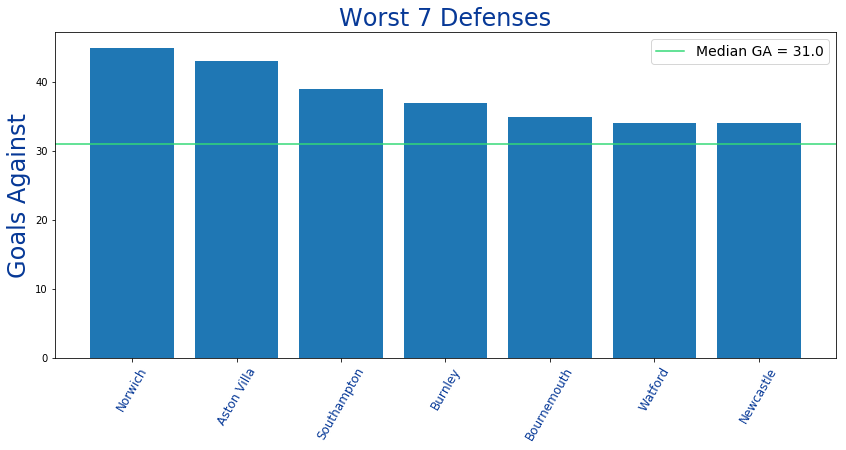

In [354]:
X = [item[0] for item in GA_bottom5]
Y = [int(item[1]) for item in GA_bottom5]

median = teams_stats.GA.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GA = ' + str(median))
plt.ylabel('Goals Against', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Worst 7 Defenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.savefig('Worst_DF', bbox_inches = 'tight')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

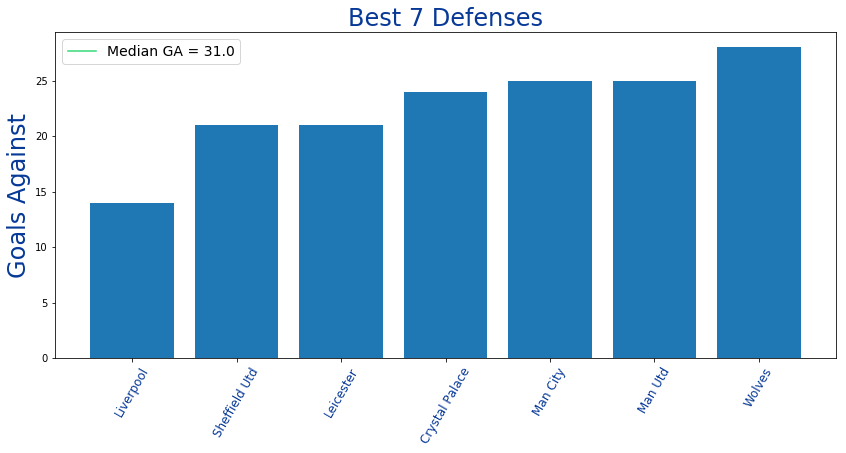

In [355]:
X = [item[0] for item in GA_top5]
Y = [int(item[1]) for item in GA_top5]

median = teams_stats.GA.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GA = ' + str(median))
plt.ylabel('Goals Against', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Best 7 Defenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.savefig('Best_DF', bbox_inches = 'tight')
plt.show

In [356]:
offense_df = teams_stats.sort_values(by = ['GF'], ascending = False)

In [357]:
offense_df.head()

,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,
2,MCI,Man City,22,15,5,2,62,25,+37,47
1,LIV,Liverpool,21,20,0,1,50,14,+36,61
3,LEI,Leicester,22,14,5,3,47,21,+26,45
4,CHE,Chelsea,22,12,7,3,39,29,+10,39
5,MUN,Man Utd,22,9,6,7,36,25,+11,34


In [358]:
GF = list(zip(offense_df.name, offense_df.GF))
GF_top5 = GF[:7]
GF_bottom5 = GF[-7:]

In [359]:
GF_top5, GF_bottom5

([('Man City', 62),
  ('Liverpool', 50),
  ('Leicester', 47),
  ('Chelsea', 39),
  ('Man Utd', 36),
  ('Spurs', 36),
  ('Wolves', 31)],
 [('Burnley', 24),
  ('Sheffield Utd', 24),
  ('Norwich', 22),
  ('Newcastle', 21),
  ('Crystal Palace', 20),
  ('Watford', 20),
  ('Bournemouth', 20)])

<function matplotlib.pyplot.show(*args, **kw)>

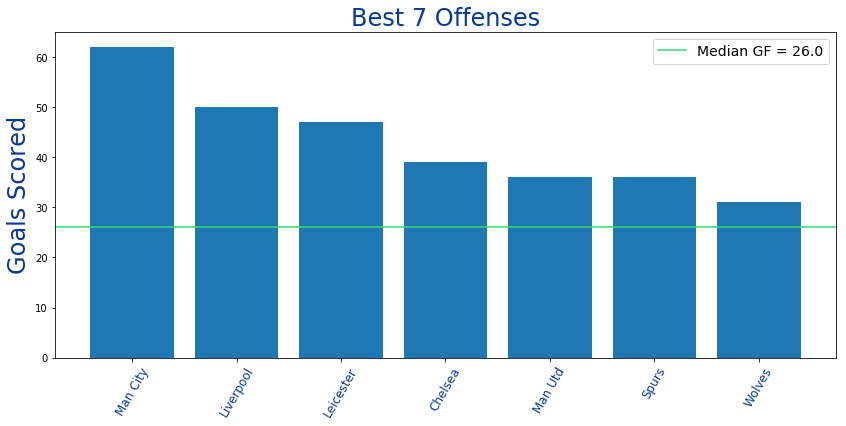

In [360]:
X = [item[0] for item in GF_top5]
Y = [int(item[1]) for item in GF_top5]

median = teams_stats.GF.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Goals Scored', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Best 7 Offenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.savefig('Best_Offense', bbox_inches = 'tight')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

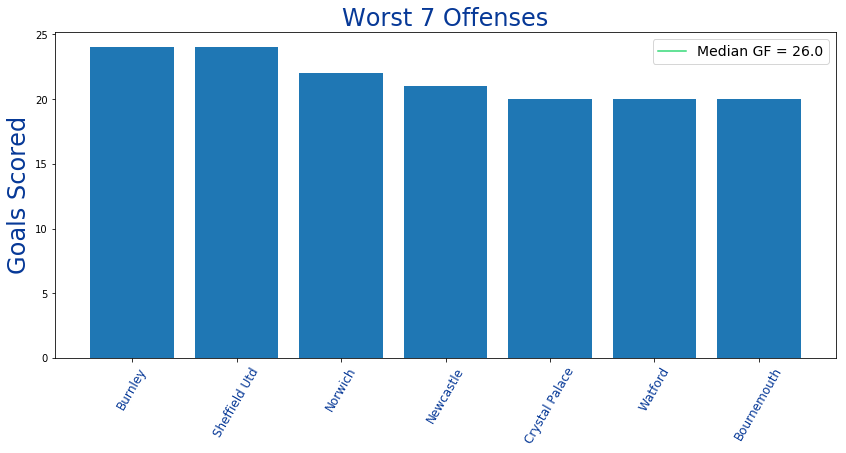

In [361]:
X = [item[0] for item in GF_bottom5]
Y = [int(item[1]) for item in GF_bottom5]

median = teams_stats.GF.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Goals Scored', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Worst 7 Offenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.savefig('Worst_Offense', bbox_inches = 'tight')
plt.show

In [362]:
stats_df = player_df[player_df.minutes >= min_min]

In [363]:
stats_df.tail()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
478,0,5.3,891,Danny Rose,Defender,1.72,0,3.21,available,6,Spurs,17,105037,211507
496,0,4.9,611,Eric Dier,Midfielder,2.21,0,3.06,available,6,Spurs,15,11690,17729
270,0,5.3,669,Dejan Lovren,Defender,2.15,0,3.02,doubtful,14,Liverpool,16,51852,63383
225,0,4.4,737,Morgan Schneiderlin,Midfielder,1.59,1,2.95,available,11,Everton,13,36725,80070
390,0,4.0,709,Grant Hanley,Defender,0.63,0,1.25,doubtful,45,Norwich,5,239890,276320


### Cobine Team and Player Stats

In [364]:
team_dic = {item:[] for item in team_names}

for row, player in stats_df.iterrows():
    for name in team_names:
        if player.team_name == name:
            playa = dict(name = player['name'], position = player.position, cost = player.cost, minutes = player.minutes, 
                         points = player.total_points,  roi = player.roi, pts_per_90min = player.pts_per_90min, 
                         bonus = player.bonus, red_cards = player.red_cards)
            team_dic[name].append(playa)

In [365]:
stats_df.head()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
422,12,5.1,1837,John Lundstram,Defender,5.09,0,20.39,available,49,Sheffield Utd,104,3407217,698233
419,7,5.1,1980,George Baldock,Defender,4.41,0,19.02,available,49,Sheffield Utd,97,1032901,246229
450,27,6.8,1526,Danny Ings,Forward,7.25,0,18.09,available,20,Southampton,123,2260695,628570
522,13,4.9,1980,Ben Foster,Goalkeeper,3.95,0,17.76,available,57,Watford,87,243015,180011
435,5,4.9,1890,Dean Henderson,Goalkeeper,4.14,0,17.76,available,49,Sheffield Utd,87,920704,341652


In [366]:
team_dic['Liverpool']

[{'name': 'Trent Alexander-Arnold',
  'position': 'Defender',
  'cost': 7.5,
  'minutes': 1842,
  'points': 118,
  'roi': 15.73,
  'pts_per_90min': 5.76,
  'bonus': 12,
  'red_cards': 0},
 {'name': 'Virgil van Dijk',
  'position': 'Defender',
  'cost': 6.4,
  'minutes': 1890,
  'points': 98,
  'roi': 15.31,
  'pts_per_90min': 4.66,
  'bonus': 8,
  'red_cards': 0},
 {'name': 'Andrew Robertson',
  'position': 'Defender',
  'cost': 7.0,
  'minutes': 1813,
  'points': 104,
  'roi': 14.86,
  'pts_per_90min': 5.16,
  'bonus': 12,
  'red_cards': 0},
 {'name': 'Sadio Mané',
  'position': 'Midfielder',
  'cost': 12.4,
  'minutes': 1663,
  'points': 143,
  'roi': 11.53,
  'pts_per_90min': 7.73,
  'bonus': 18,
  'red_cards': 0},
 {'name': 'Georginio Wijnaldum',
  'position': 'Midfielder',
  'cost': 5.4,
  'minutes': 1672,
  'points': 60,
  'roi': 11.11,
  'pts_per_90min': 3.23,
  'bonus': 3,
  'red_cards': 0},
 {'name': 'Jordan Henderson',
  'position': 'Midfielder',
  'cost': 5.4,
  'minutes': 1

### Get Final Stats per Team using Pandas

In [367]:
team_stats = {item:{} for item in team_names}

for team in team_names:
    active_players = len(stats_df[stats_df.team_name == team].cost)
    tot_cost = round(stats_df[stats_df.team_name == team].cost.sum(), 3)
    tot_pts = round(stats_df[stats_df.team_name == team].total_points.sum(), 3)
    avg_player_roi = round(tot_pts / tot_cost, 3)
    avg_pts_per_player = round(tot_pts / active_players, 3)
    
    stats = dict(active_players = active_players, tot_cost = tot_cost, tot_pts = tot_pts,
               avg_pts_per_player = avg_pts_per_player,  avg_player_roi =  avg_player_roi)
    
    team_stats[team].update(stats)
    
    

In [368]:
team_stats['Newcastle']

{'active_players': 16,
 'tot_cost': 76.9,
 'tot_pts': 720,
 'avg_pts_per_player': 45.0,
 'avg_player_roi': 9.363}

In [369]:
team_stats_df = pd.DataFrame(team_stats).T

In [370]:
team_stats_df.sort_values(by = ['avg_pts_per_player'], ascending = False, inplace = True)

In [371]:
team_stats_df

,active_players,avg_player_roi,avg_pts_per_player,tot_cost,tot_pts
Leicester,12.0,13.459,83.333,74.3,1000.0
Liverpool,15.0,10.283,70.133,102.3,1052.0
Sheffield Utd,13.0,14.022,69.462,64.4,903.0
Man City,16.0,9.336,67.688,116.0,1083.0
Wolves,13.0,11.254,60.769,70.2,790.0
Chelsea,14.0,10.063,57.071,79.4,799.0
Man Utd,13.0,9.516,56.000,76.5,728.0
Crystal Palace,14.0,10.110,52.500,72.7,735.0
Burnley,14.0,10.196,52.071,71.5,729.0
Brighton,15.0,10.177,49.800,73.4,747.0


### Build a team using 90min Stat

In [372]:
#define money team as empty list and list that tracks count of players selectd per team
money_team = []
players_selected = []
teams_selected = []

#Instantiate initial count per position
#Current players selected for each position
DF_curr = 0
MD_curr = 0 
ST_curr = 0

GK_budget = budget*GK_coef
print(GK_budget)

for item in GK_90min:
    if item['cost'] <= 5.5 and item['cost'] <= GK_budget:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        GK_budget -= item['cost']
        print('Player Selected: ' + item['name'])
        print('GK budget left: ' + str(GK_budget))
        
print(players_selected)
print(teams_selected)

9.5
Player Selected: Vicente Guaita
GK budget left: 4.4
Player Selected: Adrián San Miguel del Castillo
GK budget left: 0.3000000000000007
['Vicente Guaita', 'Adrián San Miguel del Castillo']
['Crystal Palace', 'Liverpool']


### Select top 3 players by points per position

In [373]:
DF_budget = budget*DF_coef + GK_budget
MD_budget = budget*MD_coef
ST_budget = budget*ST_coef

print(DF_budget, MD_budget, ST_budget)

#Select Top Defender
money_team.append(DF_pts[0])
players_selected.append(DF_pts[0]['name'])
teams_selected.append(DF_pts[0]['team_name'])
DF_budget -= DF_pts[0]['cost']
DF_curr += 1
print('Player Selected: ' + DF_pts[0]['name'])
print('DF budget left: ' + str(DF_budget))

#Select Top Midfielder
money_team.append(MD_pts[0])
players_selected.append(MD_pts[0]['name'])
teams_selected.append(MD_pts[0]['team_name'])
MD_budget -= MD_pts[0]['cost']
MD_curr += 1
print('Player Selected: ' + MD_pts[0]['name'])
print('MD budget left: ' + str(MD_budget))


print(players_selected)
print(teams_selected)

28.799999999999997 36.0 26.0
Player Selected: Trent Alexander-Arnold
DF budget left: 21.299999999999997
Player Selected: Kevin De Bruyne
MD budget left: 25.3
['Vicente Guaita', 'Adrián San Miguel del Castillo', 'Trent Alexander-Arnold', 'Kevin De Bruyne']
['Crystal Palace', 'Liverpool', 'Liverpool', 'Man City']


In [374]:
#Select Top Striker

for item in ST_pts[:3]:
    if teams_selected.count(item['team_name']) < 3 and len(money_team) == 4:
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
    break

print(len(money_team))
print(players_selected)
print(teams_selected)

Player Selected: Jamie Vardy
ST budget left: 15.9
5
['Vicente Guaita', 'Adrián San Miguel del Castillo', 'Trent Alexander-Arnold', 'Kevin De Bruyne', 'Jamie Vardy']
['Crystal Palace', 'Liverpool', 'Liverpool', 'Man City', 'Leicester']


In [375]:
print(DF_curr, MD_curr, ST_curr)

1 1 1


In [376]:
print(DF, MD, ST)

3 4 3


### Fill rest of team with 90_min_stats

In [377]:
for item in DF_90min:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < DF_budget and DF_curr < DF:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        DF_budget -= item['cost']
        DF_curr += 1
        print('Player Selected: ' + item['name'])
        print('DF budget left: ' + str(DF_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and DF_max != DF_curr and item['cost'] <= DF_budget / (DF_max - DF_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            DF_budget -= item['cost']
            DF_curr += 1
            print('Player Selected: ' + item['name'])
            print('DF budget left: ' + str(DF_budget))
            print('# of DFs selected: ' + str(DF_curr))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Joseph Gomez
DF budget left: 16.099999999999998
Player Selected: Reece James
DF budget left: 11.099999999999998
Player Selected: Djibril Sidibé
DF budget left: 5.6999999999999975
# of DFs selected: 4
Player Selected: Nicolás Otamendi
DF budget left: 0.6999999999999975
# of DFs selected: 5
9
['Vicente Guaita', 'Adrián San Miguel del Castillo', 'Trent Alexander-Arnold', 'Kevin De Bruyne', 'Jamie Vardy', 'Joseph Gomez', 'Reece James', 'Djibril Sidibé', 'Nicolás Otamendi']
['Crystal Palace', 'Liverpool', 'Liverpool', 'Man City', 'Leicester', 'Liverpool', 'Chelsea', 'Everton', 'Man City']


In [378]:
#move leftover DF budget to MD budget
MD_budget += DF_budget

for item in MD_90min:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < MD_budget and MD_curr < MD:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        MD_budget -= item['cost']
        MD_curr += 1
        print('Player Selected: ' + item['name'])
        print('MD budget left: ' + str(MD_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and MD_max != MD_curr and item['cost'] <= MD_budget / (MD_max - MD_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            MD_budget -= item['cost']
            MD_curr += 1
            print('Player Selected: ' + item['name'])
            print('MD budget left: ' + str(MD_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Riyad Mahrez
MD budget left: 17.5
Player Selected: Ayoze Pérez
MD budget left: 11.4
Player Selected: Heung-Min Son
MD budget left: 1.5999999999999996
12
['Vicente Guaita', 'Adrián San Miguel del Castillo', 'Trent Alexander-Arnold', 'Kevin De Bruyne', 'Jamie Vardy', 'Joseph Gomez', 'Reece James', 'Djibril Sidibé', 'Nicolás Otamendi', 'Riyad Mahrez', 'Ayoze Pérez', 'Heung-Min Son']
['Crystal Palace', 'Liverpool', 'Liverpool', 'Man City', 'Leicester', 'Liverpool', 'Chelsea', 'Everton', 'Man City', 'Man City', 'Leicester', 'Spurs']


In [379]:
#move leftover MD budget to ST budget
ST_budget += MD_budget

for item in ST_90min:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < ST_budget and ST_curr < ST:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        ST_budget -= item['cost']
        ST_curr += 1
        print('Player Selected: ' + item['name'])
        print('ST budget left: ' + str(ST_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and ST_max != ST_curr and item['cost'] <= ST_budget / (ST_max - ST_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Tammy Abraham
ST budget left: 9.7
Player Selected: Alexandre Lacazette
ST budget left: 0.3999999999999986
14
['Vicente Guaita', 'Adrián San Miguel del Castillo', 'Trent Alexander-Arnold', 'Kevin De Bruyne', 'Jamie Vardy', 'Joseph Gomez', 'Reece James', 'Djibril Sidibé', 'Nicolás Otamendi', 'Riyad Mahrez', 'Ayoze Pérez', 'Heung-Min Son', 'Tammy Abraham', 'Alexandre Lacazette']
['Crystal Palace', 'Liverpool', 'Liverpool', 'Man City', 'Leicester', 'Liverpool', 'Chelsea', 'Everton', 'Man City', 'Man City', 'Leicester', 'Spurs', 'Chelsea', 'Arsenal']


In [380]:
money_df = pd.DataFrame(money_team)

In [381]:
money_df

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,10,5.1,1800,Vicente Guaita,Goalkeeper,4.10,0,16.08,available,31,Crystal Palace,82,312805,168734
1,0,4.1,783,Adrián San Miguel del Castillo,Goalkeeper,2.87,0,6.10,available,14,Liverpool,25,621016,580888
2,12,7.5,1842,Trent Alexander-Arnold,Defender,5.76,0,15.73,available,14,Liverpool,118,2219095,1162411
3,19,10.7,1710,Kevin De Bruyne,Midfielder,7.89,0,14.02,available,43,Man City,150,4570118,2189993
4,25,10.1,1800,Jamie Vardy,Forward,7.45,0,14.75,available,13,Leicester,149,3922768,1140000
5,5,5.2,647,Joseph Gomez,Defender,6.25,0,8.65,available,14,Liverpool,45,255032,157405
6,3,5.0,601,Reece James,Defender,4.63,0,6.20,available,8,Chelsea,31,67895,42112
7,9,5.4,1119,Djibril Sidibé,Defender,4.58,0,10.56,available,11,Everton,57,199711,64103
8,2,5.0,1021,Nicolás Otamendi,Defender,4.14,0,9.40,available,43,Man City,47,694932,677975
9,12,8.5,1083,Riyad Mahrez,Midfielder,8.80,0,12.47,available,43,Man City,106,1226358,937025


<function matplotlib.pyplot.show(*args, **kw)>

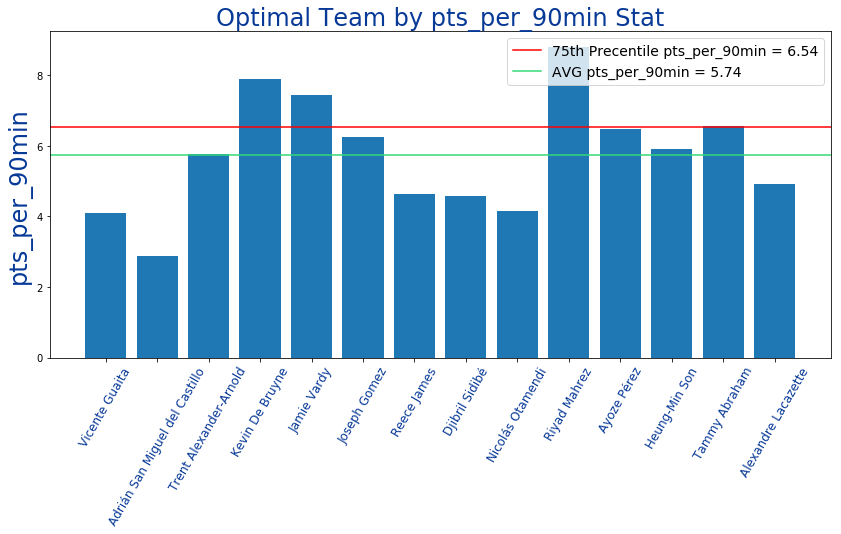

In [382]:
money_x = money_df.pts_per_90min
money_y = money_df.name
ST_75th = round(money_df.describe().pts_per_90min['75%'], 2)
ST_AVG = round(money_df.describe().pts_per_90min['mean'], 2)

plt.bar(money_y, money_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th Precentile pts_per_90min = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG pts_per_90min = ' + str(ST_AVG))
plt.ylabel('pts_per_90min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Optimal Team by pts_per_90min Stat', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('Team_pts_per90min', bbox_inches = 'tight')
plt.show

In [383]:
top100_users = pd.read_csv('fEPL_user_data_test.csv', index_col='users')

In [384]:
top100_users.head()

,rank,user_id_num,total_points,game_week_points,formation,GKP_1,GKP_2,DEF_1,DEF_2,DEF_3,...,DEF_5,MID_1,MID_2,MID_3,MID_4,MID_5,FWD_1,FWD_2,FWD_3,user_team_pages
users,,,,,,,,,,,,,,,,,,,,,
Matthew Troha,1,933902,1462,57,"{'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}",Schmeichel-LEI-start,McGovern-NOR-sub,Robertson-LIV-start,Lundstram-SHU-start,Kelly-CRY-start,...,Rico-BOU-sub,Mané-LIV-start,Traoré-WOL-start,De Bruyne-MCI-start,Willian-CHE-start,Martial-MUN-sub,Vardy-LEI-start,Aubameyang-ARS-start,Ings-SOU-start,https://fantasy.premierleague.com/entry/933902...
kenneth herlihy,2,1734934,1455,53,"{'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}",Patrício-WOL-start,Button-BHA-sub,Söyüncü-LEI-start,Alexander-Arnold-LIV-start,Lundstram-SHU-start,...,Dunk-BHA-sub,Grealish-AVL-start,Richarlison-EVE-start,Maddison-LEI-start,De Bruyne-MCI-start,Alli-TOT-sub,Calvert-Lewin-EVE-start,Ings-SOU-start,Vardy-LEI-start,https://fantasy.premierleague.com/entry/173493...
Joe Murray,3,2315483,1454,80,"{'GKP': 1, 'DEF': 4, 'MID': 3, 'FWD': 3}",Pope-BUR-start,Ryan-BHA-sub,van Dijk-LIV-start,Alexander-Arnold-LIV-start,Söyüncü-LEI-start,...,Kelly-CRY-sub,Salah-LIV-start,Richarlison-EVE-start,De Bruyne-MCI-start,Grealish-AVL-sub,Noble-WHU-sub,Ings-SOU-start,Rashford-MUN-start,Vardy-LEI-start,https://fantasy.premierleague.com/entry/231548...
Shasvind Mahi,4,1032977,1450,69,"{'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}",Fabianski-WHU-start,Gazzaniga-TOT-sub,Baldock-SHU-start,Alexander-Arnold-LIV-start,Lundstram-SHU-start,...,Kelly-CRY-sub,De Bruyne-MCI-start,Mané-LIV-start,Richarlison-EVE-start,Traoré-WOL-start,Alli-TOT-sub,Vardy-LEI-start,Ings-SOU-start,Abraham-CHE-start,https://fantasy.premierleague.com/entry/103297...
Khaled Talaat,5,402206,1449,70,"{'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}",Pope-BUR-start,Gazzaniga-TOT-sub,Holgate-EVE-start,Alexander-Arnold-LIV-start,Lundstram-SHU-start,...,Kelly-CRY-sub,Martial-MUN-start,De Bruyne-MCI-start,Maddison-LEI-start,Mané-LIV-start,Cantwell-NOR-sub,Ings-SOU-start,Vardy-LEI-start,Rashford-MUN-start,https://fantasy.premierleague.com/entry/402206...


### Get Stats of top 100 players

<function matplotlib.pyplot.show(*args, **kw)>

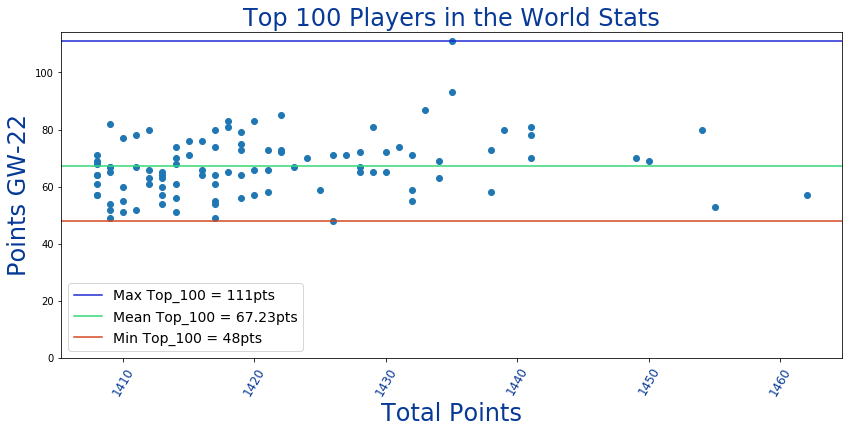

In [385]:
y =list(top100_users.game_week_points)
z =list(top100_users.total_points)

mean = np.mean(y)
maxi = np.max(y)
mini = np.min(y)

plt.scatter(z, y)
plt.ylim(bottom=0)
plt.axhline(y=maxi, color='#1D28D2', linestyle='-', label='Max Top_100 = ' + str(maxi) +'pts')
plt.axhline(y=mean, color='#33D977', linestyle='-', label='Mean Top_100 = ' + str(mean) +'pts')
plt.axhline(y=mini, color='#D2461D', linestyle='-', label='Min Top_100 = ' + str(mini) +'pts')
plt.ylabel('Points GW-'+ str(gameweek-1), fontsize = 24, color = '#073997')
plt.xlabel('Total Points', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 100 Players in the World Stats', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.savefig('Top10_Stats', bbox_inches = 'tight')
plt.show

### Function to extract names from player string

In [386]:
def partition_names(names_list):
    clean_list = [item.partition("-")[0] for item in names_list]
    return clean_list

### Function to get the list of all selected players by position

In [387]:
def get_top100_teams(team_df):
    #create lists by position
    #GK_list
    GK_list = list(team_df.GKP_1)
    GK_list.extend(list(team_df.GKP_2))
    GK_final = partition_names(GK_list)
    
    #DF_list
    DF_list = list(team_df.DEF_1)
    DF_list.extend(list(team_df.DEF_2))
    DF_list.extend(list(team_df.DEF_3))
    DF_list.extend(list(team_df.DEF_4))
    DF_list.extend(list(team_df.DEF_5))
    DF_final = partition_names(DF_list)
    
    #MD_list
    MD_list = list(team_df.MID_1)
    MD_list.extend(list(team_df.MID_2))
    MD_list.extend(list(team_df.MID_3))
    MD_list.extend(list(team_df.MID_4))
    MD_list.extend(list(team_df.MID_5))
    MD_final = partition_names(MD_list)
    
    #ST_list
    ST_list = list(team_df.FWD_1)
    ST_list.extend(list(team_df.FWD_2))
    ST_list.extend(list(team_df.FWD_3))
    ST_final = partition_names(ST_list)
    
    return GK_final, DF_final, MD_final, ST_final

In [388]:
#get the final clean list of players per position
GK_final, DF_final, MD_final, ST_final = get_top100_teams(top100_users)[0], get_top100_teams(top100_users)[1], get_top100_teams(top100_users)[2], get_top100_teams(top100_users)[3]

In [389]:
GK_final[:3]

['Schmeichel', 'Patrício', 'Pope']

In [390]:
MD_final[:3]

['Mané', 'Grealish', 'Salah']

In [391]:
DF_final[:3]

['Robertson', 'Söyüncü', 'van Dijk']

In [392]:
ST_final[:3]

['Vardy', 'Calvert', 'Ings']

### Function to get you top_n players by position ordered by # of times they were picked

In [393]:
def return_top_n(players, top_n = 10):
    ranked = Counter(players).most_common(top_n)
    return ranked

In [394]:
GK_top10 = return_top_n(GK_final)

In [395]:
GK_top10

[('Ryan', 34),
 ('Button', 28),
 ('Henderson', 23),
 ('Pope', 21),
 ('Schmeichel', 18),
 ('Gazzaniga', 14),
 ('Martin', 10),
 ('Fabianski', 8),
 ('Stekelenburg', 7),
 ('McGovern', 6)]

In [396]:
DF_top10 = return_top_n(DF_final)

In [397]:
DF_top10

[('Lundstram', 96),
 ('Alexander', 86),
 ('Kelly', 64),
 ('Söyüncü', 55),
 ('Rico', 28),
 ('Robertson', 22),
 ('Baldock', 13),
 ('van Dijk', 12),
 ('Holgate', 12),
 ('Pereira', 12)]

In [398]:
MD_top10 = return_top_n(MD_final)

In [399]:
MD_top10

[('De Bruyne', 98),
 ('Mané', 69),
 ('Maddison', 46),
 ('Cantwell', 42),
 ('Martial', 41),
 ('Grealish', 40),
 ('Richarlison', 28),
 ('Salah', 27),
 ('Traoré', 21),
 ('Mahrez', 12)]

In [400]:
ST_top10 = return_top_n(ST_final)

In [401]:
ST_top10

[('Vardy', 94),
 ('Ings', 72),
 ('Rashford', 36),
 ('Abraham', 35),
 ('Jiménez', 32),
 ('Calvert', 10),
 ('Agüero', 6),
 ('Aubameyang', 3),
 ('Greenwood', 3),
 ('Firmino', 2)]

<function matplotlib.pyplot.show(*args, **kw)>

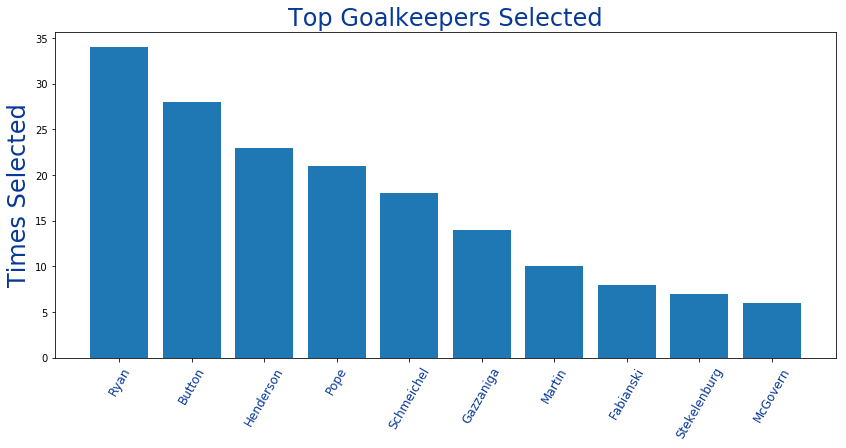

In [402]:
X = [item[0] for item in GK_top10]
Y = [item[1] for item in GK_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Goalkeepers Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.savefig('Top100_GK', bbox_inches = 'tight')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

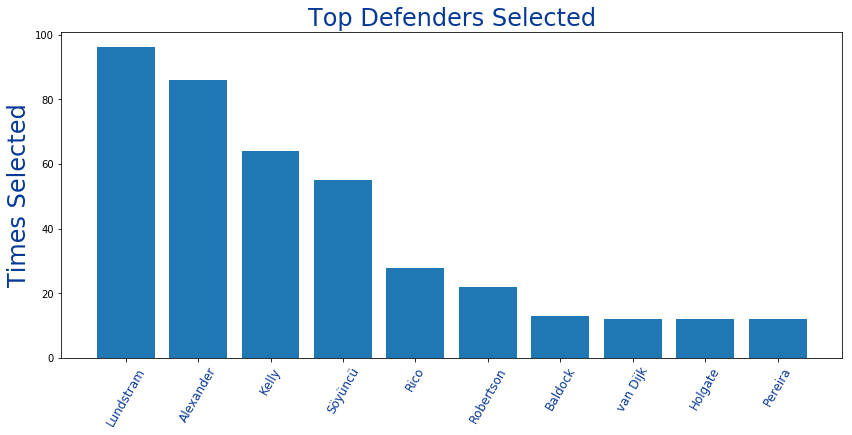

In [403]:
X = [item[0] for item in DF_top10]
Y = [item[1] for item in DF_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Defenders Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.savefig('Top100_DF', bbox_inches = 'tight')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

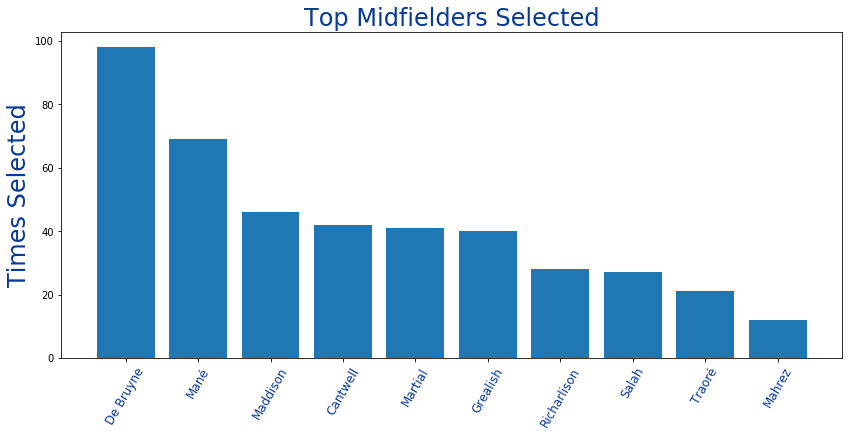

In [404]:
X = [item[0] for item in MD_top10]
Y = [item[1] for item in MD_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Midfielders Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.savefig('Top100_MD', bbox_inches = 'tight')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

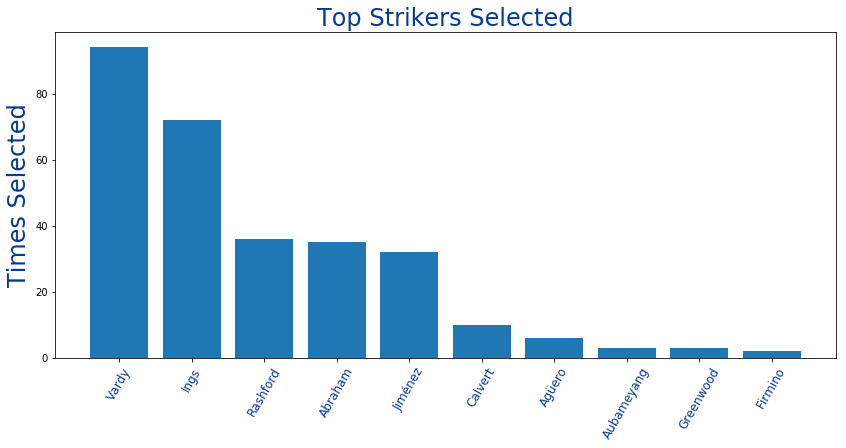

In [405]:
X = [item[0] for item in ST_top10]
Y = [item[1] for item in ST_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Strikers Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.savefig('Top100_ST', bbox_inches = 'tight')
plt.show

In [406]:
top_managers_team = GK_top10[:2]+ DF_top10[:5] + MD_top10[:5] + ST_top10[:3]

In [407]:
top_managers_team

[('Ryan', 34),
 ('Button', 28),
 ('Lundstram', 96),
 ('Alexander', 86),
 ('Kelly', 64),
 ('Söyüncü', 55),
 ('Rico', 28),
 ('De Bruyne', 98),
 ('Mané', 69),
 ('Maddison', 46),
 ('Cantwell', 42),
 ('Martial', 41),
 ('Vardy', 94),
 ('Ings', 72),
 ('Rashford', 36)]

<function matplotlib.pyplot.show(*args, **kw)>

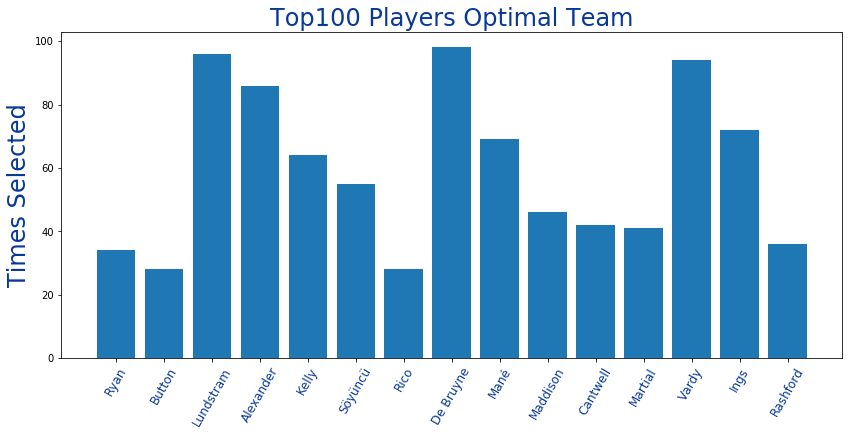

In [408]:
X = [item[0] for item in top_managers_team]
Y = [item[1] for item in top_managers_team]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top100 Players Optimal Team', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.savefig('Top100_Team', bbox_inches = 'tight')
plt.show

### Latest Injury Updates from independant site that updates faster than the Fantasy site

In [409]:
injuries = 'http://www.premierinjuries.com/?fbclid=IwAR1Uz0TTwRMOvsq1jlefIztPPg7qtPdnag3zrHxh_39wV4CZoMG0ZWq6MYU'
injuries_tab = pd.read_html(injuries)[0]

In [410]:
injuries_tab

,Player,Reason
0,Adam Webster,Other
1,Shane Duffy,Groin/Hip/Pelvic Injury
2,Alireza Jahanbakhsh,Other
3,Arthur Masuaku,Knee Injury
4,Chris Wood,Head/Face Injury
5,Ruben Vinagre,Thigh Injury
6,Marcus Rashford,Lower Back Injury
7,Sead Kolasinac,Thigh Injury
8,Abdoulaye Doucoure,Other
9,Robbie Brady,Calf/Shin/Heel Injury


In [411]:
top100_users.head()

,rank,user_id_num,total_points,game_week_points,formation,GKP_1,GKP_2,DEF_1,DEF_2,DEF_3,...,DEF_5,MID_1,MID_2,MID_3,MID_4,MID_5,FWD_1,FWD_2,FWD_3,user_team_pages
users,,,,,,,,,,,,,,,,,,,,,
Matthew Troha,1,933902,1462,57,"{'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}",Schmeichel-LEI-start,McGovern-NOR-sub,Robertson-LIV-start,Lundstram-SHU-start,Kelly-CRY-start,...,Rico-BOU-sub,Mané-LIV-start,Traoré-WOL-start,De Bruyne-MCI-start,Willian-CHE-start,Martial-MUN-sub,Vardy-LEI-start,Aubameyang-ARS-start,Ings-SOU-start,https://fantasy.premierleague.com/entry/933902...
kenneth herlihy,2,1734934,1455,53,"{'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}",Patrício-WOL-start,Button-BHA-sub,Söyüncü-LEI-start,Alexander-Arnold-LIV-start,Lundstram-SHU-start,...,Dunk-BHA-sub,Grealish-AVL-start,Richarlison-EVE-start,Maddison-LEI-start,De Bruyne-MCI-start,Alli-TOT-sub,Calvert-Lewin-EVE-start,Ings-SOU-start,Vardy-LEI-start,https://fantasy.premierleague.com/entry/173493...
Joe Murray,3,2315483,1454,80,"{'GKP': 1, 'DEF': 4, 'MID': 3, 'FWD': 3}",Pope-BUR-start,Ryan-BHA-sub,van Dijk-LIV-start,Alexander-Arnold-LIV-start,Söyüncü-LEI-start,...,Kelly-CRY-sub,Salah-LIV-start,Richarlison-EVE-start,De Bruyne-MCI-start,Grealish-AVL-sub,Noble-WHU-sub,Ings-SOU-start,Rashford-MUN-start,Vardy-LEI-start,https://fantasy.premierleague.com/entry/231548...
Shasvind Mahi,4,1032977,1450,69,"{'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}",Fabianski-WHU-start,Gazzaniga-TOT-sub,Baldock-SHU-start,Alexander-Arnold-LIV-start,Lundstram-SHU-start,...,Kelly-CRY-sub,De Bruyne-MCI-start,Mané-LIV-start,Richarlison-EVE-start,Traoré-WOL-start,Alli-TOT-sub,Vardy-LEI-start,Ings-SOU-start,Abraham-CHE-start,https://fantasy.premierleague.com/entry/103297...
Khaled Talaat,5,402206,1449,70,"{'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}",Pope-BUR-start,Gazzaniga-TOT-sub,Holgate-EVE-start,Alexander-Arnold-LIV-start,Lundstram-SHU-start,...,Kelly-CRY-sub,Martial-MUN-start,De Bruyne-MCI-start,Maddison-LEI-start,Mané-LIV-start,Cantwell-NOR-sub,Ings-SOU-start,Vardy-LEI-start,Rashford-MUN-start,https://fantasy.premierleague.com/entry/402206...


In [412]:
test = top100_users.formation

### Extract formations as a list in a readable format

In [413]:
formations = [item.split(",")[1][8] + "-" + item.split(",")[2][8] + "-" + item.split(",")[3][8] for item in test]

In [414]:
formations[:5]

['3-4-3', '3-4-3', '4-3-3', '3-4-3', '3-4-3']

### Use top_n function to get a tuple of ranked formations by count

In [415]:
top_form = return_top_n(formations, 6)

In [416]:
top_form

[('3-4-3', 72),
 ('4-3-3', 12),
 ('4-4-2', 7),
 ('3-5-2', 6),
 ('5-3-2', 2),
 ('5-2-3', 1)]

<function matplotlib.pyplot.show(*args, **kw)>

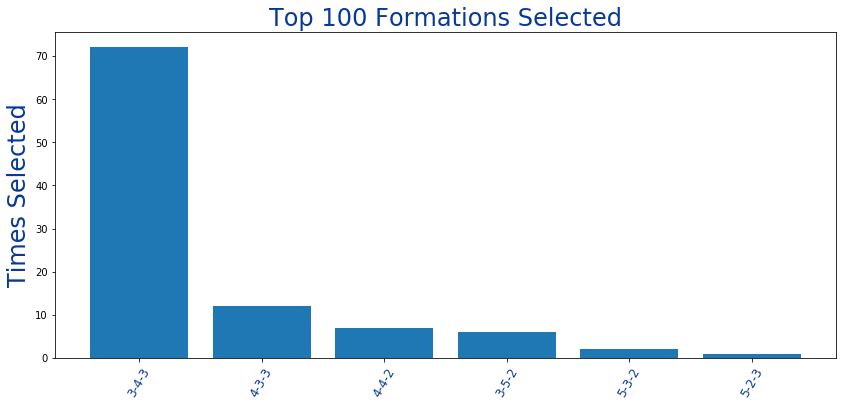

In [417]:
X = [item[0] for item in top_form]
Y = [item[1] for item in top_form]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 100 Formations Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.savefig('Top100_Forma', bbox_inches = 'tight')
plt.show